In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle

sys.path.append(os.path.abspath("../analysis_tools/"))
from utils import * 

# pycytominer imports
from pycytominer import aggregate, annotate, normalize, feature_select
from pycytominer import feature_select

# load first few rows from parquet
import fastparquet

# for median absolute deviatio
import scipy.stats as ss
from scipy.special import logit

# for Louvain clustering
import community as community_louvain
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
import scipy.spatial as spt

# make cell crops
import skimage.io

# for legends heatmap annotations
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# upset plots
from upsetplot import generate_counts, plot
from upsetplot import UpSet


In [2]:
# Import other datasets
# Anderson data
anderson_data = \
    pd.read_csv('../LMNA_PBv2b_T3_pycytominer_pipelinev2_121624/anderson_2021_variantdata_Formatted.csv')

# Clinvar
clinvar_variants_filterconditions = \
    pd.read_csv('../LMNA_PBv2b_T3_pycytominer_pipelinev2_121624/clinvar_LMNA_missense_ex345_061824_fixed.csv')
condition_map = {'DCM':'DCM', 'Myopathy':'EDMD', 'Lipodystrophy':'FPLD', 'Progeria':'HGPS'}
for disease in ['DCM','Myopathy','Lipodystrophy','Progeria']:
    clinvar_variants_filterconditions[disease] = \
        clinvar_variants_filterconditions["Mapped Conditions"]\
            .map(lambda x: True if condition_map[disease] in x else False)

# Define one way to color variants, use when highlighting specific variants
variant_type_palette = \
    {'Single Missense':'grey',
     'Synonymous':'darkgreen',
     'WT':'grey', 
     'Frameshift':'purple', 
     '3nt Deletion':'grey', 
     'Nonsense':'purple', 
     'Other':'grey'}

# AlphaMissense scores filtered by spliceAI scores
lmna_variants_spliceAIfiltered = \
    pd.read_csv('./LMNA_AM_CV.csv')


In [3]:
# Import Gwen's ROC AUC
roc_auc_lmna = pd.read_csv('../Gwen_ROC/LMNA/results/train_results.csv')
roc_auc_lmna = roc_auc_lmna[['aaChanges','test_roc_auc']].rename(columns={'aaChanges':'Variant','test_roc_auc':'AUC ROC'})
roc_auc_lmna['Morphological Distinguishability'] = roc_auc_lmna['AUC ROC'].map(lambda x: max(2*x-1,0))


In [4]:
# EVE variants
lmna_variants_EVE = \
    pd.read_csv('./LMNA_HUMAN.csv')
lmna_variants_EVE = lmna_variants_EVE[['wt_aa','position','mt_aa','EVE_scores_ASM','uncertainty_ASM']]
lmna_variants_EVE = lmna_variants_EVE.dropna(axis=0)
lmna_variants_EVE['Variant'] = \
    lmna_variants_EVE.apply(lambda row: row['wt_aa']+str(row['position']) + row['mt_aa'], axis=1)
lmna_variants_EVE = lmna_variants_EVE[['Variant','EVE_scores_ASM','uncertainty_ASM']]


In [5]:
# REVEL variants
lmna_variants_REVEL = \
    pd.read_csv('./REVEL_LMNA.csv')
lmna_variants_REVEL = \
    lmna_variants_REVEL[lmna_variants_REVEL['tag'].isin(['CCDS'])]

# 2. Load the GTF for GRCh38 (replace with your GTF filename)
gtf = pd.read_csv(
    './Homo_sapiens.GRCh38.104.gtf.gz',
    sep='\t',
    comment='#',
    header=None,
    names=['chrom','source','feature','start','end','score','strand','frame','attribute']
)

# 3. Filter to the CDS exons of the MANE Select transcript
transcript_id = 'ENST00000368300'
mask = (
    (gtf['feature'] == 'CDS') &
    (gtf['attribute'].str.contains(f'transcript_id "{transcript_id}"')) &
    (gtf['chrom'].isin([1,'1','chr1']))
)
cds = gtf[mask].copy()

# 4. Order exons in transcript order
strand = cds['strand'].iat[0]
cds = cds.sort_values('start', ascending=(strand == '+'))
intervals = cds[['start','end']].values.tolist()

# 5. Map a genomic position to its 1‑based protein residue number
def genomic_to_residue(pos):
    cds_pos = 0
    for start, end in intervals:
        if pos < start:
            continue
        if pos > end:
            cds_pos += (end - start + 1)
            continue
        # pos is within this exon
        cds_pos += (pos - start + 1)
        return ((cds_pos - 1) // 3) + 1
    return None

# 6. Apply to get the residue number, dropping rows where it is NaN
lmna_variants_REVEL['aa_pos'] = pd.to_numeric(lmna_variants_REVEL['grch38_pos'].apply(genomic_to_residue), errors='coerce')
lmna_variants_REVEL = lmna_variants_REVEL.dropna(subset=['aa_pos']).copy()

# 7. Build the variant label
lmna_variants_REVEL['Variant'] = lmna_variants_REVEL['aaref'] + lmna_variants_REVEL['aa_pos'].astype(int).astype(str) + lmna_variants_REVEL['aaalt']
lmna_variants_REVEL = lmna_variants_REVEL[['Variant','REVEL']]


In [ ]:
# LMNA information
start_pos = 178
end_pos = 273
LMNA_domain_map = {}
for pos in range(start_pos, end_pos+1):
    if pos < 222:
        LMNA_domain_map[pos] = "Coil 1B"
    elif pos <= 241:
        LMNA_domain_map[pos] = "Linker 12"
    else:
        LMNA_domain_map[pos] = "Coil 2A"
LMNA_domain_colors = \
    {
        'Coil 1B':'goldenrod',
        'Linker 12':'lime',
        'Coil 2A':'deepskyblue'
    }

# Set up for making feature plots
LMNA_WT_nuc_seq = \
    'ATGGAGACCCCGTCCCAGCGGCGCGCCACCCGCAGCGGGGCGCAGGCCAGCTCCACTCCGCTGTCGCCCACCCGCATCACCCGGCTGCAGGAGAAGGAGGACCTGCAGGAGCTCAATGATCGCTTGGCGGTCTACATCGACCGTGTGCGCTCGCTGGAAACGGAGAACGCAGGGCTGCGCCTTCGCATCACCGAGTCTGAAGAGGTGGTCAGCCGCGAGGTGTCCGGCATCAAGGCCGCCTACGAGGCCGAGCTCGGGGATGCCCGCAAGACCCTTGACTCAGTAGCCAAGGAGCGCGCCCGCCTGCAGCTGGAGCTGAGCAAAGTGCGTGAGGAGTTTAAGGAGCTGAAAGCGCGCAATACCAAGAAGGAGGGTGACCTGATAGCTGCTCAGGCTCGGCTGAAGGACCTGGAGGCTCTGCTGAACTCCAAGGAGGCCGCACTGAGCACTGCTCTCAGTGAGAAGCGCACGCTGGAGGGCGAGCTGCATGATCTGCGGGGCCAGGTGGCCAAGCTTGAGGCAGCCCTAGGTGAGGCCAAGAAACAGCTGCAGGACGAAATGCTGCGGCGGGTGGATGCTGAGAACAGGCTGCAGACCATGAAGGAGGAACTGGACTTCCAGAAGAACATCTACAGTGAGGAGCTGCGTGAGACCAAGCGCCGTCATGAGACCCGACTGGTGGAGATTGACAATGGGAAGCAGCGTGAGTTTGAGAGCCGGCTGGCGGATGCGCTGCAGGAACTGCGGGCCCAGCATGAGGACCAGGTGGAGCAGTATAAGAAGGAGCTGGAGAAGACTTATTCTGCCAAGCTGGACAATGCCAGGCAGTCTGCTGAGAGGAACAGCAACCTGGTGGGGGCTGCCCACGAGGAGCTGCAGCAGTCGCGCATCCGCATCGACAGCCTCTCTGCCCAGCTCAGCCAGCTCCAGAAGCAGCTGGCAGCCAAGGAGGCGAAGCTTCGAGACCTGGAGGACTCACTGGCCCGTGAGCGGGACACCAGCCGGCGGCTGCTGGCGGAAAAGGAGCGGGAGATGGCCGAGATGCGGGCAAGGATGCAGCAGCAGCTGGACGAGTACCAGGAGCTTCTGGACATCAAGCTGGCCCTGGACATGGAGATCCACGCCTACCGCAAGCTCTTGGAGGGCGAGGAGGAGAGGCTACGCCTGTCCCCCAGCCCTACCTCGCAGCGCAGCCGTGGCCGTGCTTCCTCTCACTCATCCCAGACACAGGGTGGGGGCAGCGTCACCAAAAAGCGCAAACTGGAGTCCACTGAGAGCCGCAGCAGCTTCTCACAGCACGCACGCACTAGCGGGCGCGTGGCCGTGGAGGAGGTGGATGAGGAGGGCAAGTTTGTCCGGCTGCGCAACAAGTCCAATGAGGACCAGTCCATGGGCAATTGGCAGAtCAAGCGCCAGAATGGAGACGACCCACTGCTCACCTACCGGTTCCCACCAAAGTTCACCCTGAAGGCTGGGCAGGTGGTGACGATCTGGGCTGCAGGAGCTGGGGCCACCCACAGCCCCCCTACCGACCTGGTGTGGAAGGCACAGAACACCTGGGGCTGCGGGAACAGCCTGCGTACGGCTCtCATCAACTCCACTGGGGAAGAAGTGGCCATGCGCAAGCTGGTGCGCTCAGTGACTGTGGTTGAGGACGACGAGGATGAGGATGGAGATGACCTGCTCCATCACCACCACGGCTCCCACTGCAGCAGCTCGGGGGACCCCGCTGAGTACAACCTGCGCTCGCGCACCGTGCTGTGCGGGACCTGCGGGCAGCCTGCCGACAAGGCATCTGCCAGCGGCTCAGGAGCCCAGGTGGGCGGACCCATCTCCTCTGGCTCTTCTGCCTCCAGTGTCACGGTCACTCGCAGCTACCGCAGTGTGGGGGGCAGTGGGGGTGGCAGCTTCGGGGACAATCTGGTCACCCGCTCCTACCTCCTGGGCAACTCCAGCCCCCGAACCCAGAGCCCCCAGAACTGCAGCATCATGTAG'
LMNA_WT_aa_seq = \
    str(Seq(LMNA_WT_nuc_seq).translate())
lmna_pymol_view = \
    '''set_view (\
        -0.915147185,    0.403044611,   -0.007183676,\
        -0.175614133,   -0.414666086,   -0.892865419,\
        -0.362844229,   -0.815845907,    0.450264663,\
         0.000000000,    0.000000000, -382.015167236,\
      -190.245574951, -108.335136414,  109.851905823,\
       301.183654785,  462.846679688,  -20.000000000 )'''
lmna_pymol_view2 = \
    '''set_view (\
     0.071904697,   -0.778118074,   -0.623987436,\
     0.870689154,    0.354146332,   -0.341291487,\
     0.486548126,   -0.518758714,    0.702964723,\
     0.000000000,    0.000000000, -374.783477783,\
    -2.406383991,  -20.413566589,  -11.670532227,\
   295.482147217,  454.084808350,  -20.000000000 )'''


In [35]:
# Read profiles
df_profiles_merged = pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_clusterlabeled_021325.csv', index_col=None)
df_profiles_merged.drop(columns='Unnamed: 0',inplace=True)
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'], 
                   ordered=True)
features_common = [c for c in df_profiles_merged.columns if c not in ['Variant','Variant_Class',
                                                                      'NCells_R1','NCells_R2',
                                                                      'UMAP1','UMAP2',
                                                                      'Louvain Cluster']]

# Read p-values
df_KSpvalues_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_KSpvalues_010924.csv')
df_KSpvalues_merged.index = df_KSpvalues_merged['Variant']
df_KSpvalues_merged.drop(columns='Variant',inplace=True)

# Read features
variant_medians_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_featuremedians_010625.csv')
variant_medians_merged.drop(columns='Unnamed: 0', inplace=True)
variant_medians_merged['Variant_Class'] = \
    pd.Categorical(variant_medians_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'],
                   ordered=True)
variant_EMD_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_featureEMD_010925.csv')
variant_EMD_merged.drop(columns='Unnamed: 0', inplace=True)
variant_EMD_merged['Variant_Class'] = \
    pd.Categorical(variant_EMD_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'],
                   ordered=True)

# Read selected differential features by Louvain Cluster
rank_sum_bycluster_df = \
    pd.read_csv('./merged_clusters_differentialfeatures_011225.csv')

# Get umap coordinates
umap_coords = \
    df_profiles_merged[['Variant','UMAP1','UMAP2']]

# Highlight biochemical controls
punctuate_controls = ['N195K','L248P','E203G','R189P']
non_punctuate_controls = ['D192V', 'R189W', 'E203K', 'E203V', 'E262K', 'E202K', 'R190Q']
total_controls = punctuate_controls + non_punctuate_controls
umap_coords['Highlight'] = \
    umap_coords['Variant'].map(lambda x: True if x in total_controls else False)
umap_coords['HighlightClass'] = \
    umap_coords['Variant'].map(lambda x: 'Punctuate' if x in punctuate_controls \
                                               else 'Non-Punctuate' if x in non_punctuate_controls \
                                               else 'WT' if x == 'WT' \
                                                else np.nan)


In [36]:
# Plot impact as a function of aa to
aliphatic = ["A", "V", "I", "L", "G"]
aromatic = ["F", "Y", "W"]
nonpolar = ["C", "M", "P"]
polar = ["S", "T", "N", "Q"]
acidic = ["D", "E"]
basic = ["H", "K", "R"]
aa_type = aliphatic+aromatic+nonpolar+polar+acidic+basic
palette_aato={}
palette_aato['Syn']='green'
for t in aliphatic:
    palette_aato[t]='tan'
for t in aromatic:
    palette_aato[t]='darkorange'
for t in nonpolar:
    palette_aato[t]='gold'
for t in polar:
    palette_aato[t]='cyan'
for t in acidic:
    palette_aato[t]='red'
for t in basic:
    palette_aato[t]='cornflowerblue'

df_toplot = df_profiles_merged.query('Variant_Class in ["Synonymous","Single Missense"]').copy()
df_toplot['AA To'] = \
    df_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class']=='Synonymous' else row['Variant'][-1],axis=1)
fig, ax = plt.subplots(figsize=(6,4))
boxplot_with_significance(
    df=df_toplot,
    x_col='AA To',
    y_col='Morphological Impact Score',
    hue_col='AA To',  # same as x_col
    order=['Syn']+aa_type,
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Syn",t) for t in aa_type],
    palette=palette_aato,
    offset=0.005,
    ax=ax,
    anno_sample_sizes=False
)

plt.ylim(0, 1)
plt.tight_layout()
plt.ylabel('Morphological Impact Score', fontsize=16)
plt.xlabel('')
plt.tick_params(labelsize=14)
plt.close()
fig.savefig('./consensus_plots/morphological_impact.aato.011325.pdf', dpi=600, bbox_inches='tight')


In [37]:
# Plot impact as a function of aa to
aliphatic = ["A", "V", "I", "L", "G"]
aromatic = ["F", "Y", "W"]
nonpolar = ["C", "M", "P"]
polar = ["S", "T", "N", "Q"]
acidic = ["D", "E"]
basic = ["H", "K", "R"]
aa_type = aliphatic+aromatic+nonpolar+polar+acidic+basic
palette_aato={}
palette_aato['Syn']='green'
for t in aliphatic:
    palette_aato[t]='tan'
for t in aromatic:
    palette_aato[t]='darkorange'
for t in nonpolar:
    palette_aato[t]='gold'
for t in polar:
    palette_aato[t]='cyan'
for t in acidic:
    palette_aato[t]='red'
for t in basic:
    palette_aato[t]='cornflowerblue'

df_toplot = df_profiles_merged.query('Variant_Class in ["Synonymous","Single Missense"]').copy()
df_toplot['AA To'] = \
    df_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class']=='Synonymous' else row['Variant'][-1],axis=1)
df_toplot = \
    df_toplot.merge(roc_auc_lmna, on='Variant', how='inner')
fig, ax = plt.subplots(figsize=(6,4))
boxplot_with_significance(
    df=df_toplot,
    x_col='AA To',
    y_col='AUC ROC',
    hue_col='AA To',  # same as x_col
    order=['Syn']+aa_type,
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Syn",t) for t in aa_type],
    palette=palette_aato,
    offset=0.005,
    ax=ax,
    anno_sample_sizes=False
)

plt.ylim(0.45, 1)
plt.tight_layout()
plt.ylabel('AUC ROC', fontsize=16)
plt.xlabel('')
plt.tick_params(labelsize=14)
plt.close()
fig.savefig('./consensus_plots/auc_roc.aato.052725.pdf', dpi=600, bbox_inches='tight')


In [38]:
# Combine all features
df_features_tot = \
    df_profiles_merged[['Variant',
                        'NCells_R1','NCells_R2',
                        'Variant_Class',
                        'UMAP1','UMAP2',
                        'Cluster',
                        'Morphological Impact Score']]\
        .merge(variant_medians_merged\
                   .drop(columns='Variant_Class')\
                   .rename(columns={c:c+'_median' for c in variant_medians_merged.columns if "Variant" not in c}),
               on='Variant'
              )\
        .merge(variant_EMD_merged\
                   .drop(columns='Variant_Class')\
                   .rename(columns={c:c+'_EMD' for c in variant_medians_merged.columns if "Variant" not in c}),
               on='Variant')


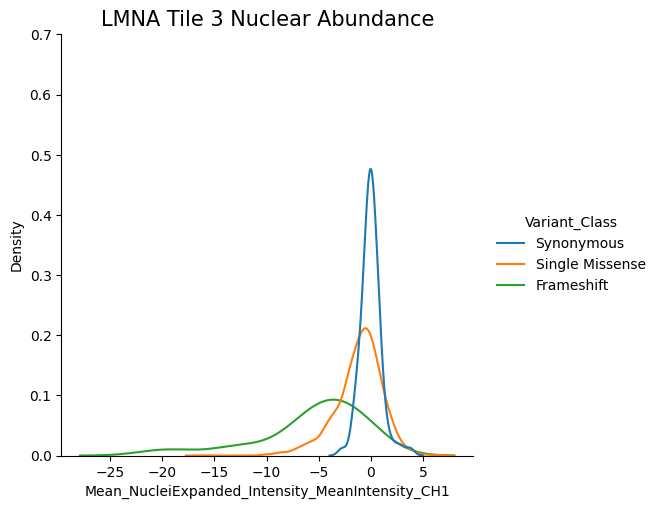

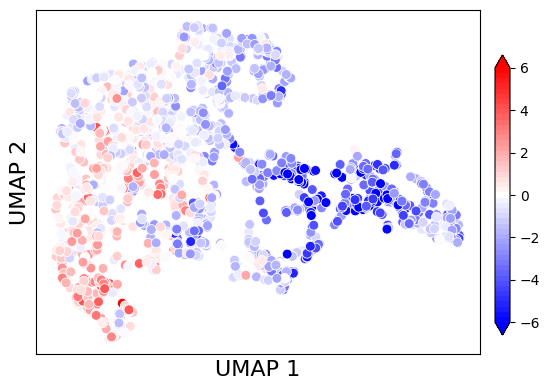

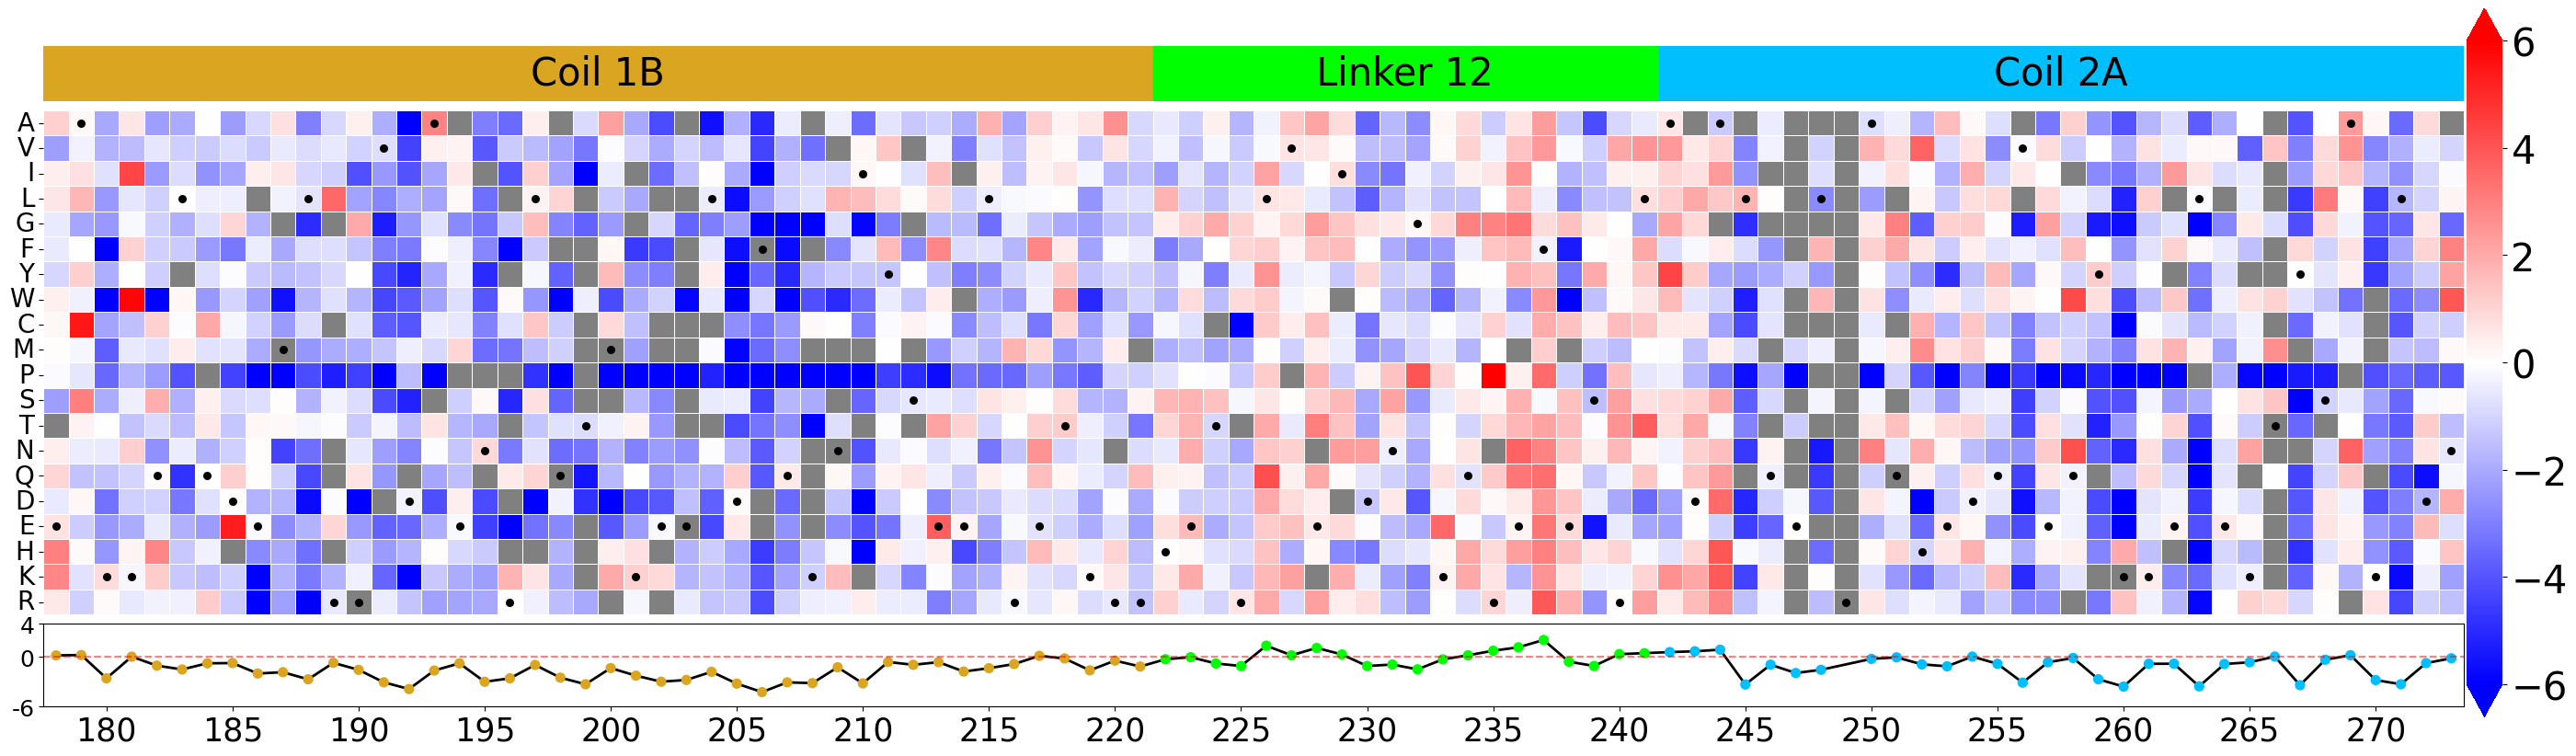

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.abundance".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.58 sec. = 6244.6 frames/hour (0.58 sec. accum.).
PyMOL>png ./consensus_plots/pdb/6jlb_

In [50]:
# Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Abundance",
                 "LMNA.T3.abundance",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6)
!{pymol_command}


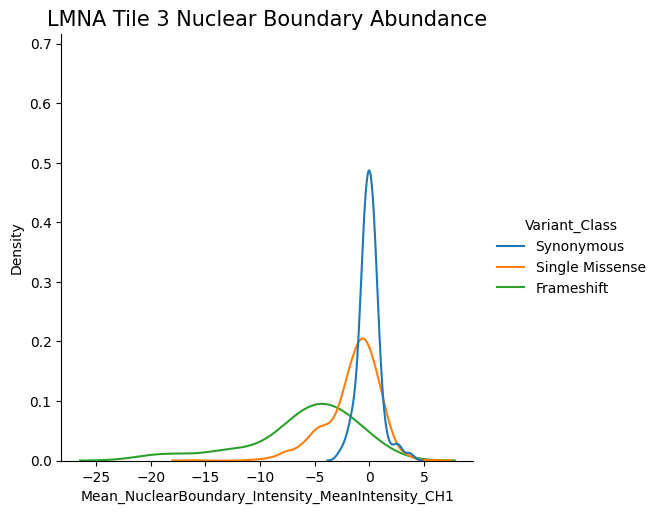

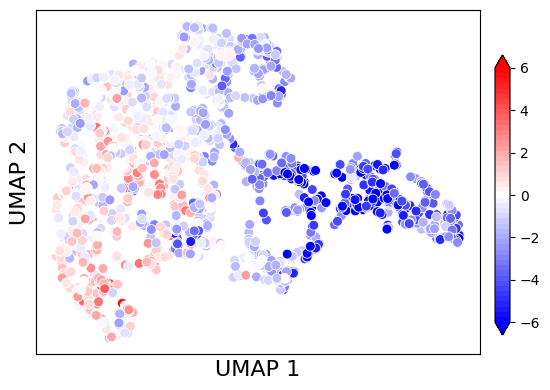

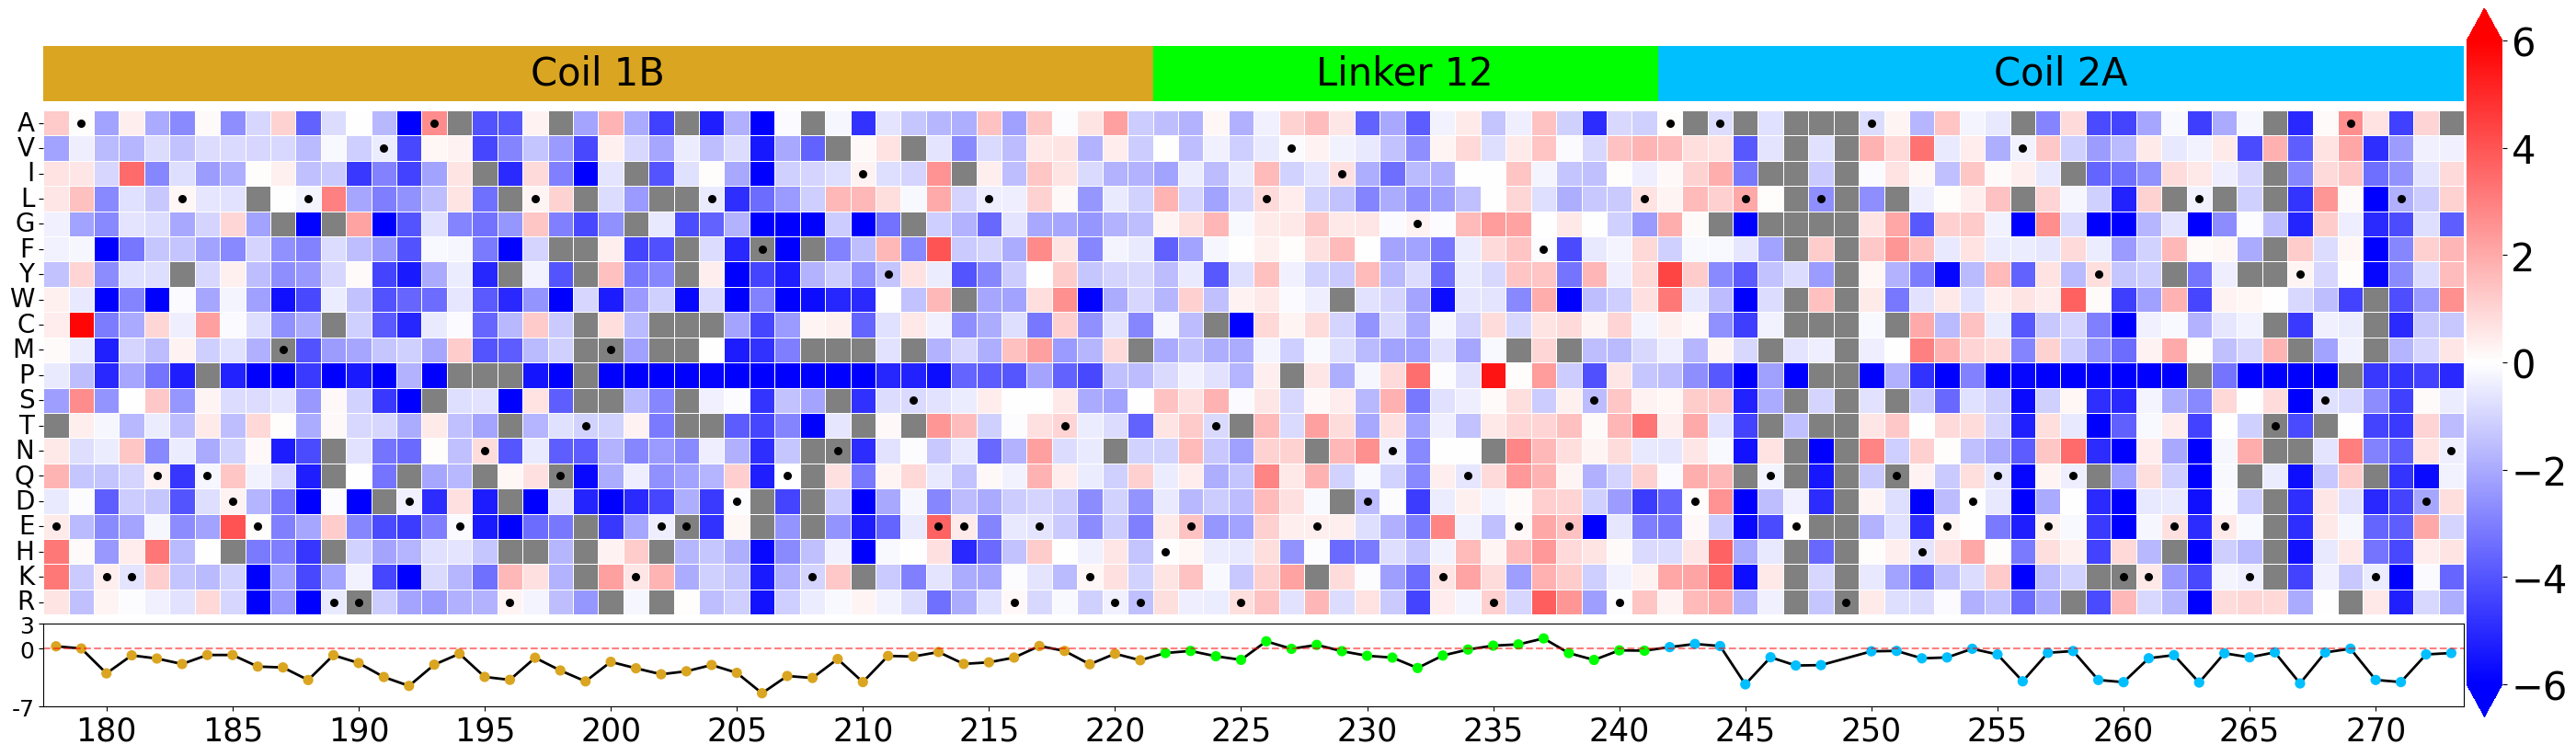

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.boundaryabundance".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.58 sec. = 6193.8 frames/hour (0.58 sec. accum.).
PyMOL>png ./consensus_plots/p

In [51]:
# Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Boundary Abundance",
                 "LMNA.T3.boundaryabundance",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6)
!{pymol_command}


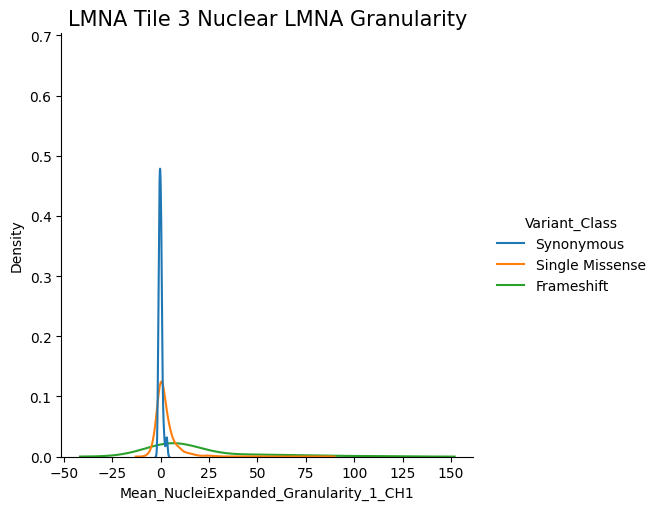

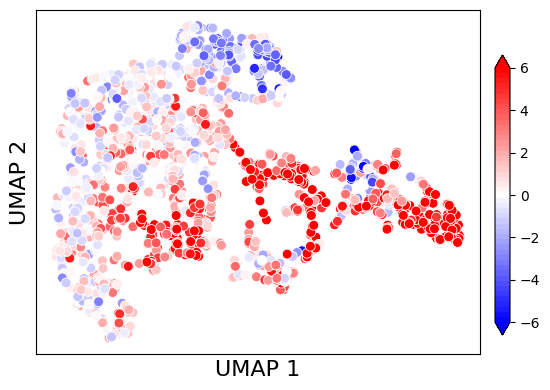

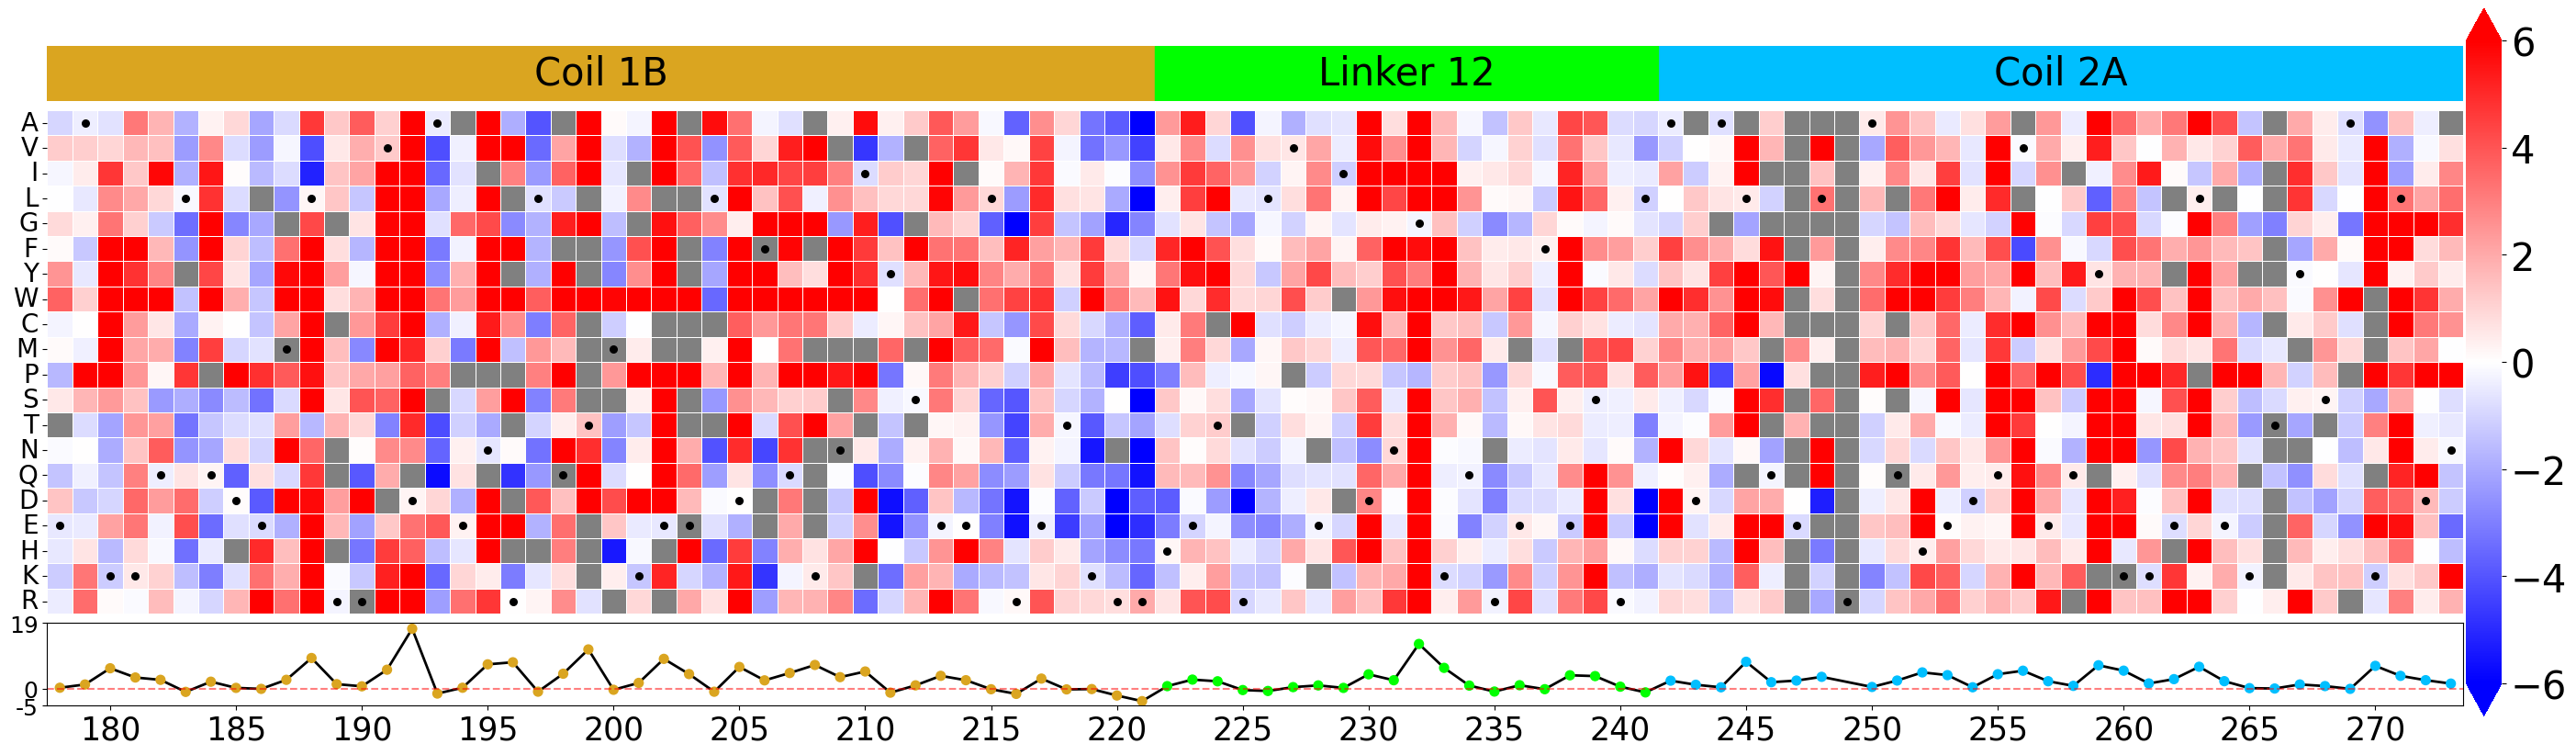

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.LMNAGranularity1".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.56 sec. = 6484.4 frames/hour (0.56 sec. accum.).
PyMOL>png ./consensus_plots/pd

In [52]:
# Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_NucleiExpanded_Granularity_1_CH1'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear LMNA Granularity",
                 "LMNA.T3.LMNAGranularity1",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6)
!{pymol_command}


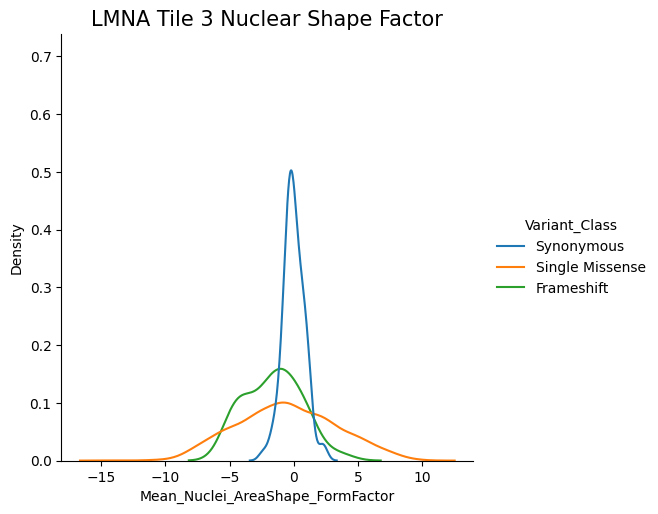

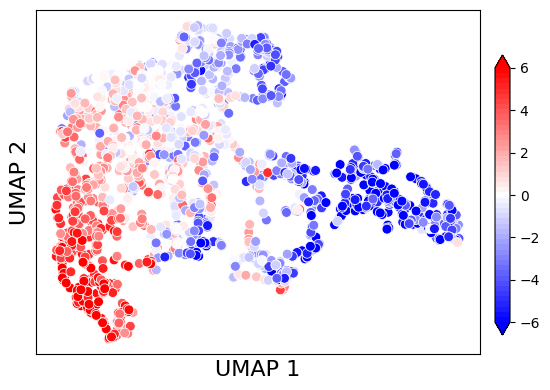

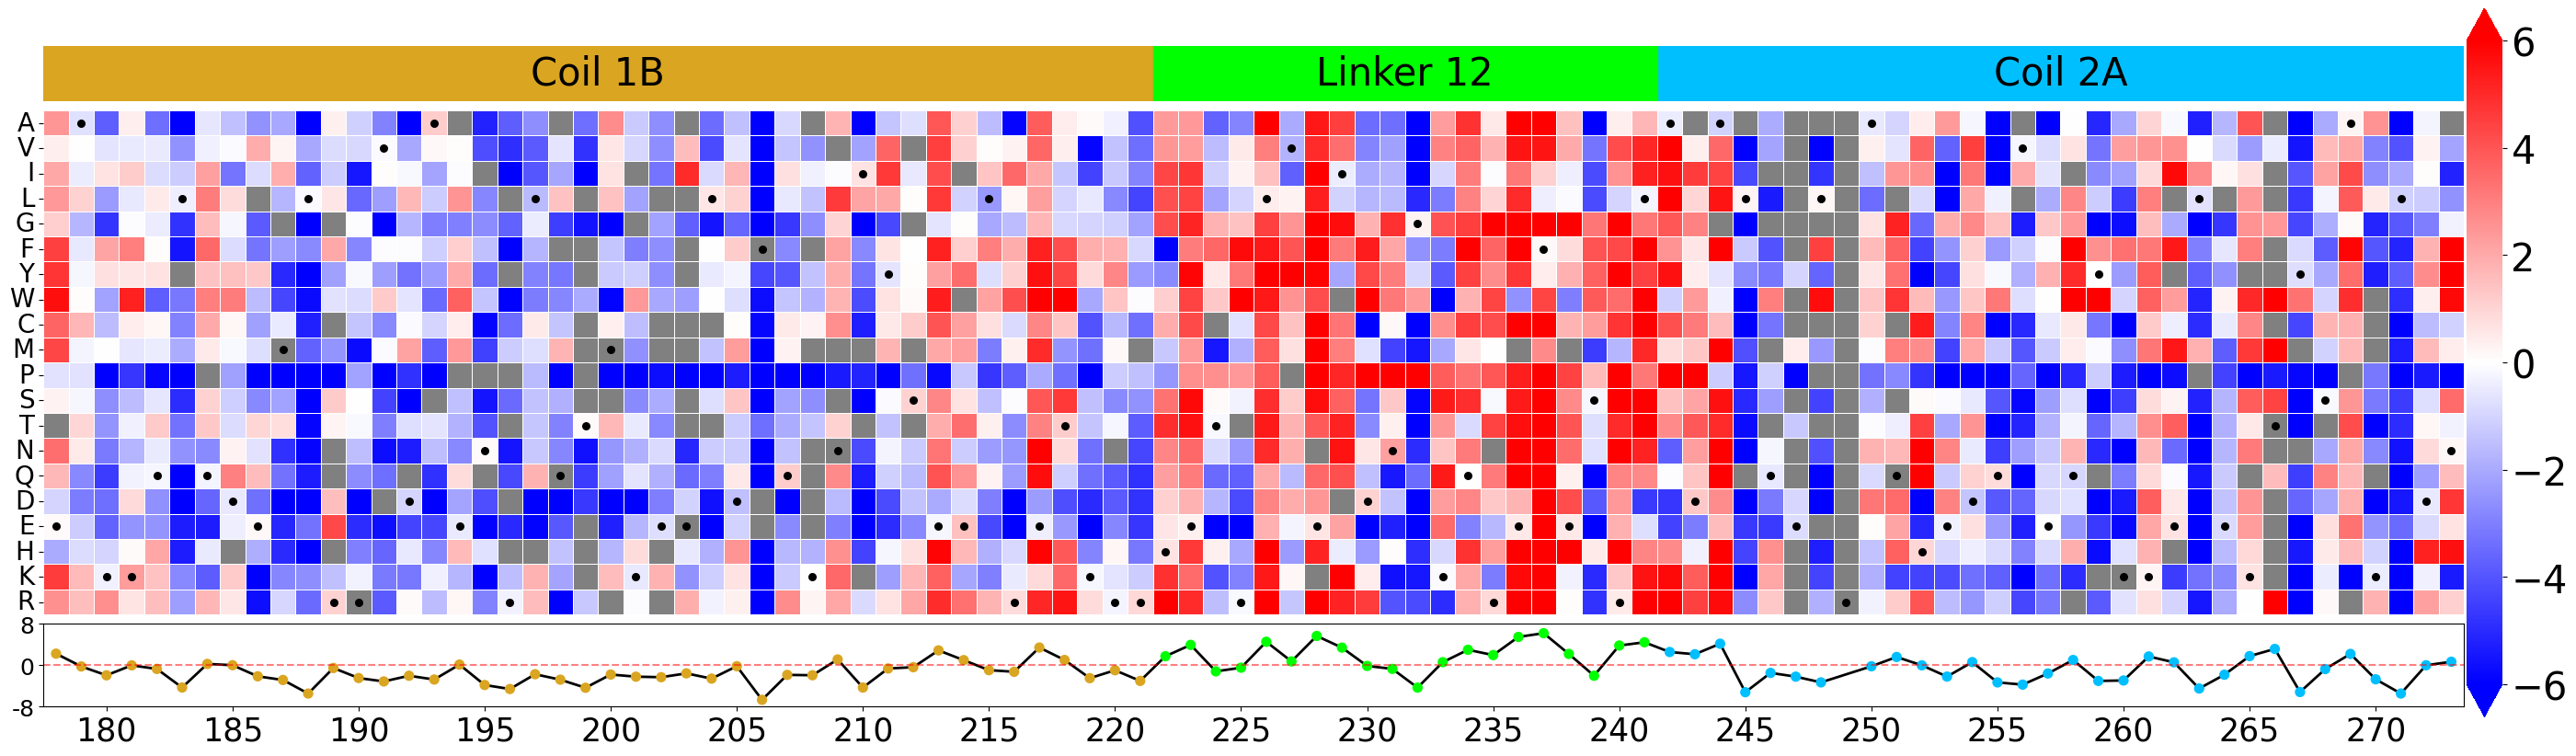

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.NucleiShapeFactor".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.58 sec. = 6259.4 frames/hour (0.58 sec. accum.).
PyMOL>png ./consensus_plots/p

In [53]:
## Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_Nuclei_AreaShape_FormFactor'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Shape Factor",
                 "LMNA.T3.NucleiShapeFactor",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6
                )
!{pymol_command}


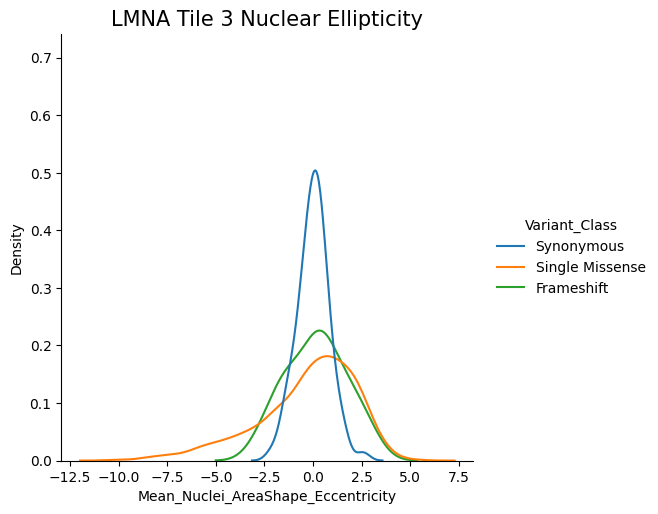

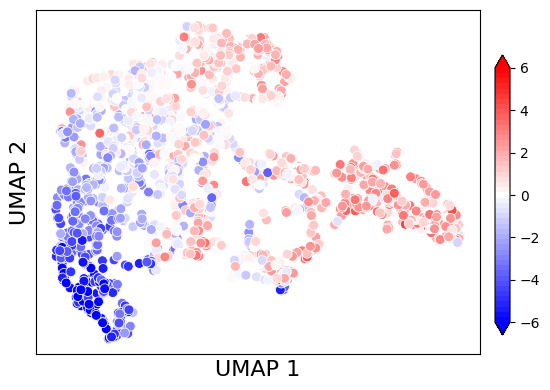

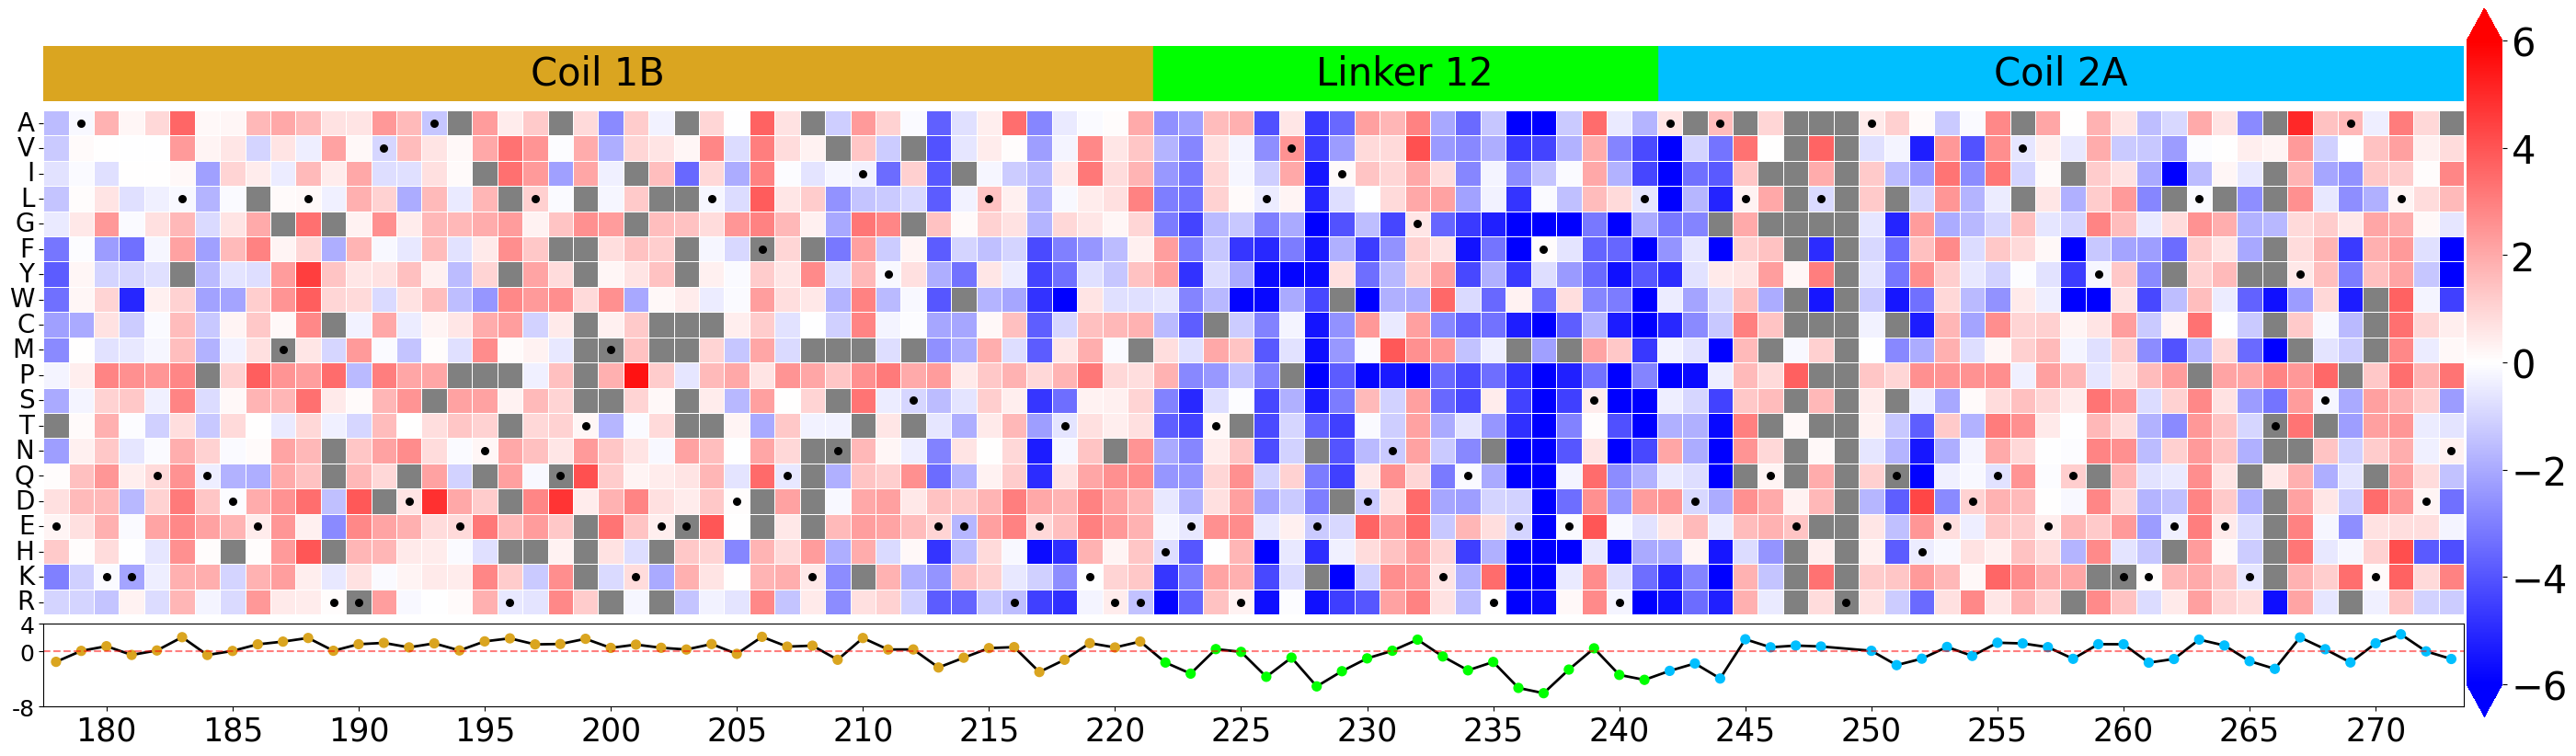

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.NucleiEllipticity".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.57 sec. = 6356.5 frames/hour (0.57 sec. accum.).
PyMOL>png ./consensus_plots/p

In [54]:
## Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_Nuclei_AreaShape_Eccentricity'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Ellipticity",
                 "LMNA.T3.NucleiEllipticity",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6
                )
!{pymol_command}


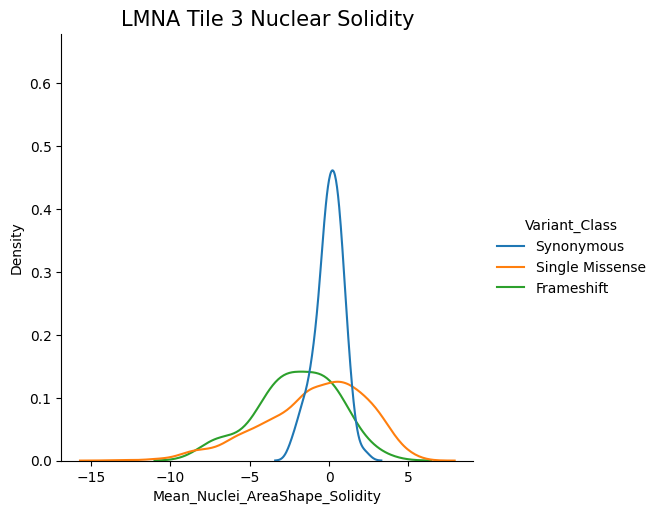

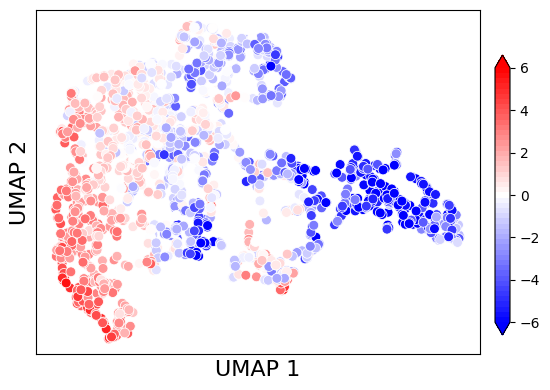

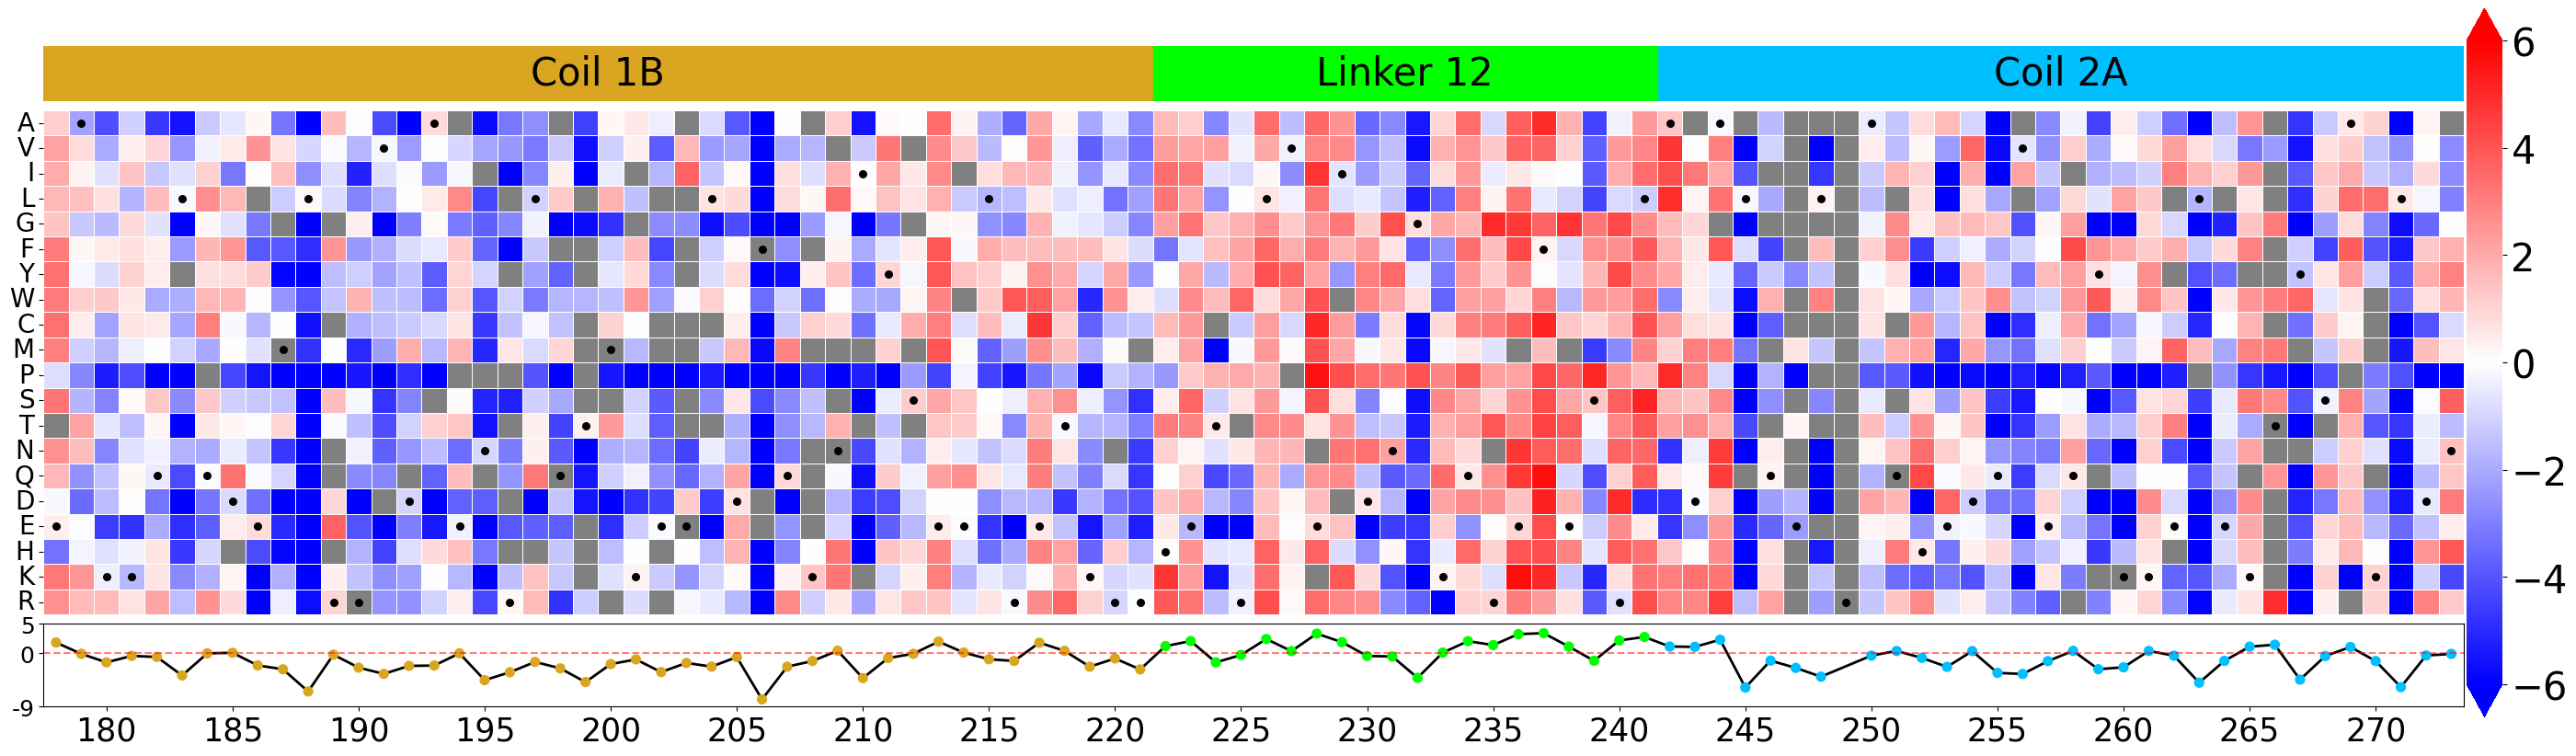

 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA.T3.NucleiSolidity".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, blue_white_red, sele, minimum=-6, maximum=6
 Spectrum: range (-6.00000 to  6.00000).
PyMOL>show sticks
PyMOL>ray
 Ray: render time: 0.57 sec. = 6335.4 frames/hour (0.57 sec. accum.).
PyMOL>png ./consensus_plots/pdb/

In [55]:
## Look at specific features, adding domain annotation onto heatmaps
feature_to_heatmap = 'Mean_Nuclei_AreaShape_Solidity'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Solidity",
                 "LMNA.T3.NucleiSolidity",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6
                )
!{pymol_command}


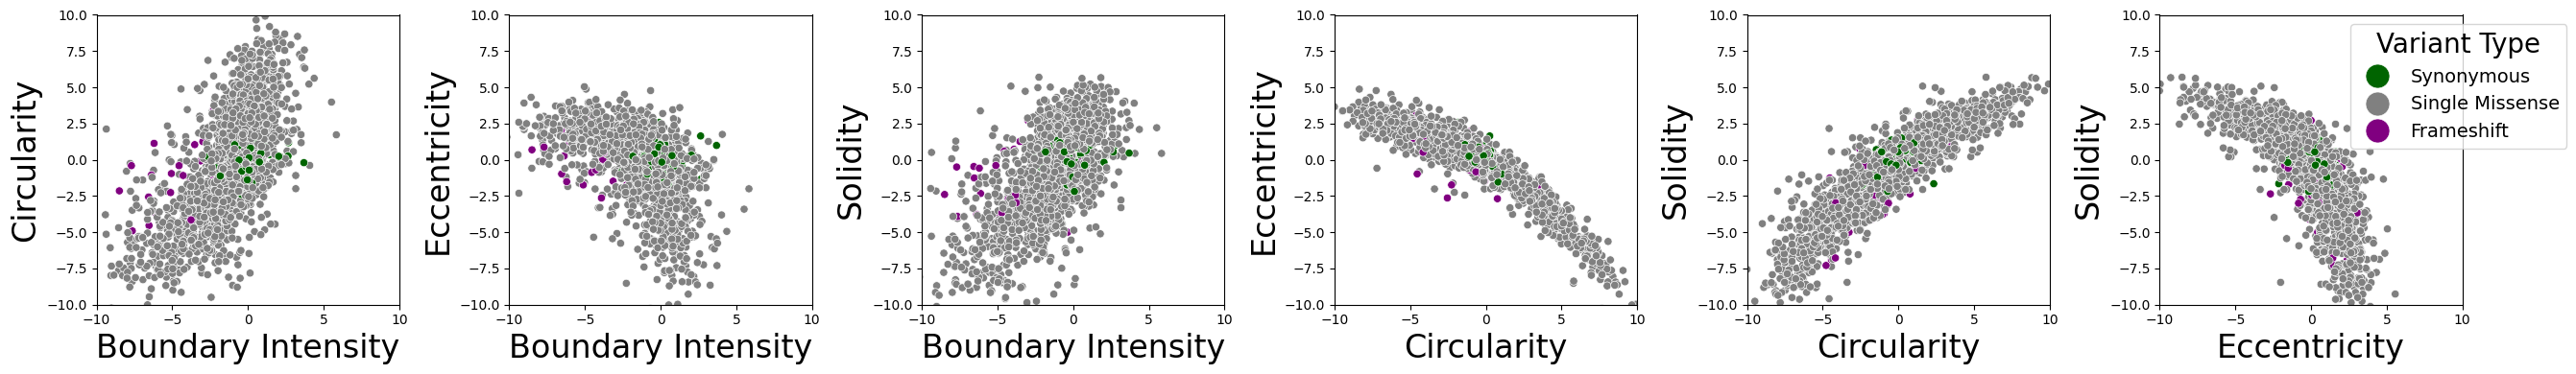

In [46]:
# Ellipticity vs circularity plot
# Plot the three major features against each other for iPS and neurons
feature_list_toplot = \
    [
        'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
        'Mean_Nuclei_AreaShape_FormFactor', 
        'Mean_Nuclei_AreaShape_Eccentricity',
        'Mean_Nuclei_AreaShape_Solidity'
    ]

axis_lims_features = \
    {
        l:(-10,10) for l in feature_list_toplot
    }

feature_rename = \
    {
        'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1':'Boundary Intensity',
        'Mean_Nuclei_AreaShape_FormFactor':'Circularity', 
        'Mean_Nuclei_AreaShape_Eccentricity':'Eccentricity',
        'Mean_Nuclei_AreaShape_Solidity':'Solidity'
    }

feature_pairs_toplot = list(itertools.combinations(feature_list_toplot, 2))
fig,axs = plt.subplots(figsize=(4*len(feature_pairs_toplot)+3,4),ncols=len(feature_pairs_toplot))
for i,pair in enumerate(feature_pairs_toplot):
    sns.scatterplot(
        data=variant_medians_merged,
        x=pair[0],
        y=pair[1],
        hue='Variant_Class',
        palette=variant_type_palette,
        ax=axs[i],
        legend=(i==(len(feature_pairs_toplot)-1))
    )
    axs[i].set_xlabel(feature_rename[pair[0]], fontsize=24)
    axs[i].set_ylabel(feature_rename[pair[1]], fontsize=24)
    axs[i].set_xlim(axis_lims_features[pair[0]])
    axs[i].set_ylim(axis_lims_features[pair[1]])
plt.legend(loc='upper left',
           title='Variant Type',
           markerscale=3,
           bbox_to_anchor=(0.6,1),
           fontsize=14,
           title_fontsize=20)
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.pairwisenuclearshapeplot.022725.pdf',
            bbox_inches='tight')
plt.show()


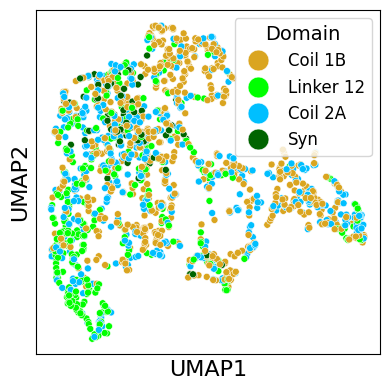

In [47]:
# Plot by domain
variants_assayed_umap_toplot = \
    df_profiles_merged[df_profiles_merged['Variant_Class'].isin(['Single Missense','Synonymous'])]

# Annotate with domain information
variants_assayed_umap_toplot['position'] = \
    variants_assayed_umap_toplot['Variant'].map(lambda x: int(x[1:-1]))
variants_assayed_umap_toplot['Domain'] = \
    variants_assayed_umap_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class'] == 'Synonymous'\
                                else LMNA_domain_map[row['position']],
               axis=1)
fig,ax=plt.subplots(figsize=(4,4))
domain_cp = {**LMNA_domain_colors, 'Syn': 'darkgreen'}
sns.scatterplot(data=variants_assayed_umap_toplot, 
                x='UMAP1', y='UMAP2', 
                hue='Domain', 
                palette=domain_cp,
                s=25,
                ax=ax
               )

plt.legend(markerscale=3, fontsize=12, title='Domain', title_fontsize=14)
# Remove x-axis tick labels and ticks
plt.xticks([])
plt.xlabel('UMAP1', fontsize=16)

# Remove y-axis tick labels and ticks
plt.yticks([])
plt.ylabel('UMAP2', fontsize=16)
plt.tight_layout()

plt.show()
fig.savefig('./consensus_plots/LMNAT3.UMAP.domain.011325.pdf', 
            dpi=600
           )


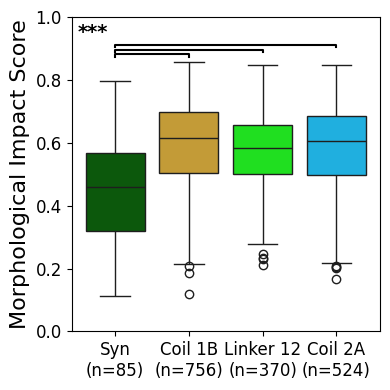

In [48]:
# Look at variants based on where they are in structure
df_toplot = df_profiles_merged.query('Variant_Class in ["Synonymous","Single Missense"]')
df_toplot['Position'] = df_toplot['Variant'].map(lambda x: int(x[1:-1]))
df_toplot['Domain'] = \
    df_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class'] == 'Synonymous'\
                                else LMNA_domain_map[row['Position']],
               axis=1)

fig,ax=plt.subplots(figsize=(4,4))
domain_cp = {**LMNA_domain_colors, 'Syn': 'darkgreen'}
boxplot_with_significance(
    df=df_toplot,
    x_col='Domain',
    y_col='Morphological Impact Score',
    hue_col='Domain',
    palette=domain_cp,
    order=['Syn','Coil 1B','Linker 12','Coil 2A'],
    alpha=0.001,    # Show significance if p < 0.001
    pairs=list(itertools.combinations(['Syn','Coil 1B','Linker 12','Coil 2A'],2)),
    offset=0.02,
    ax=ax
)
plt.ylabel('Morphological Impact Score', fontsize=16)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/morphologicalimpact.bydomain.011325.pdf')


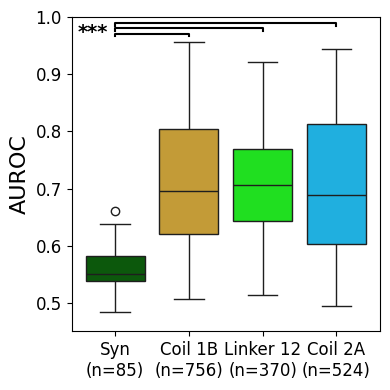

In [49]:
# Look at variants based on where they are in structure
df_toplot = df_profiles_merged.query('Variant_Class in ["Synonymous","Single Missense"]')
df_toplot['Position'] = df_toplot['Variant'].map(lambda x: int(x[1:-1]))
df_toplot['Domain'] = \
    df_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class'] == 'Synonymous'\
                                else LMNA_domain_map[row['Position']],
               axis=1)
df_toplot = \
    df_toplot.merge(roc_auc_lmna, on='Variant')

fig,ax=plt.subplots(figsize=(4,4))
domain_cp = {**LMNA_domain_colors, 'Syn': 'darkgreen'}
boxplot_with_significance(
    df=df_toplot,
    x_col='Domain',
    y_col='AUC ROC',
    hue_col='Domain',
    palette=domain_cp,
    order=['Syn','Coil 1B','Linker 12','Coil 2A'],
    alpha=0.001,    # Show significance if p < 0.001
    pairs=list(itertools.combinations(['Syn','Coil 1B','Linker 12','Coil 2A'],2)),
    offset=0.02,
    ax=ax
)
plt.ylabel('AUROC', fontsize=16)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.45,1)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/auc_roc.bydomain.052725.pdf')


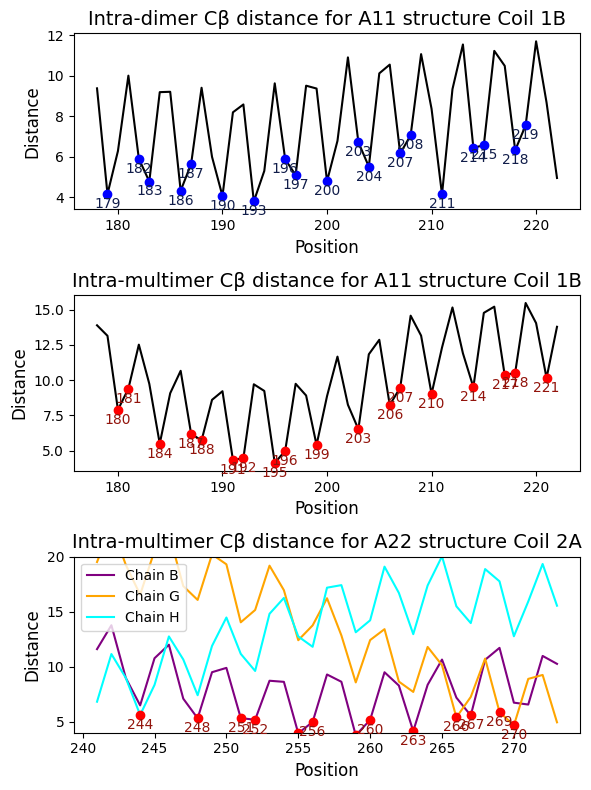

In [56]:
# Get tetramer and dimer interacting positions
neighbor_from_minima_dist=1.5 #distance from minimum to count as

#A11 structure Ahn et al 2019 first
nearest_dist_a11tetramer = \
    get_nearest_distance_dataframe("./6jlb.pdb")
nearest_dist_a11tetramer['Ref_position'] = nearest_dist_a11tetramer['Ref_residue'].map(lambda x: int(x[1:]))
nearest_dist_a11tetramer['Nearest_position_chainA'] = nearest_dist_a11tetramer['Nearest_residue_chainA'].map(lambda x: int(x[1:]))
nearest_dist_a11tetramer['Nearest_position_chainB'] = nearest_dist_a11tetramer['Nearest_residue_chainB'].map(lambda x: int(x[1:]))
nearest_dist_a11tetramer['Nearest_position_chainD'] = nearest_dist_a11tetramer['Nearest_residue_chainD'].map(lambda x: int(x[1:]))
nearest_dist_a11tetramer_coil1B = \
    nearest_dist_a11tetramer\
        .query("Ref_position >= @start_pos & Ref_position <= @end_pos")\
        .query('Ref_position <= 222')

# Plot dimer positions for A11 - coil 1B
fig, axs = plt.subplots(nrows=3, figsize=(6,8))
axs[0].plot(nearest_dist_a11tetramer_coil1B['Ref_position'],
            nearest_dist_a11tetramer_coil1B['Dist_residue_chainD'],
            label="Distance",
            c='black')
axs[0].set_title('Intra-dimer C\u03b2 distance for A11 structure Coil 1B', fontsize=14)
axs[0].set_xlabel('Position',fontsize=12)
axs[0].set_ylabel('Distance',fontsize=12)

# Get the x and y data as numpy arrays
x = nearest_dist_a11tetramer_coil1B['Ref_position'].values
y = nearest_dist_a11tetramer_coil1B['Dist_residue_chainD'].values

# Identify local minima: indices where a point is lower than its immediate neighbors.
minima_indices = np.where((y[1:-1] < y[:-2]) & (y[1:-1] < y[2:]))[0] + 1

# Use a set to collect unique annotated positions.
annotated_positions = set()

# Mark and annotate local minima and their neighbors if the distance difference is less than 1.
for idx in minima_indices:
    # Mark and annotate the local minimum (red)
    annotated_positions.add(x[idx])
    axs[0].plot(x[idx], y[idx], 'bo')
    axs[0].annotate(f"{x[idx]}", (x[idx], y[idx]),
                textcoords="offset points", xytext=(0, -10), ha="center", color='#111D4A')
    
    # Check left neighbor, if it exists.
    if idx - 1 >= 0:
        diff_left = y[idx-1] - y[idx]
        if diff_left < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[0].plot(x[idx-1], y[idx-1], 'bo')  # Mark with blue circle.
            axs[0].annotate(f"{x[idx-1]}", (x[idx-1], y[idx-1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#111D4A')
    
    # Check right neighbor, if it exists.
    if idx + 1 < len(y):
        diff_right = y[idx+1] - y[idx]
        if diff_right < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[0].plot(x[idx+1], y[idx+1], 'bo')
            axs[0].annotate(f"{x[idx+1]}", (x[idx+1], y[idx+1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#111D4A')

coil1b_dimer_pos = list(sorted(annotated_positions))

# Plot tetramer positions for A11 - coil 1B
axs[1].plot(nearest_dist_a11tetramer_coil1B['Ref_position'],
            nearest_dist_a11tetramer_coil1B['Dist_residue_chainA'],
            label="Distance",
            c='black')
axs[1].set_title('Intra-multimer C\u03b2 distance for A11 structure Coil 1B',fontsize=14)
axs[1].set_xlabel('Position',fontsize=12)
axs[1].set_ylabel('Distance',fontsize=12)

# Get the x and y data as numpy arrays
x = nearest_dist_a11tetramer_coil1B['Ref_position'].values
y = nearest_dist_a11tetramer_coil1B['Dist_residue_chainA'].values

# Identify local minima: indices where a point is lower than its immediate neighbors.
minima_indices = np.where((y[1:-1] < y[:-2]) & (y[1:-1] < y[2:]))[0] + 1

# Use a set to collect unique annotated positions.
annotated_positions = set()

# Mark and annotate local minima and their neighbors if the distance difference is less than 1.
for idx in minima_indices:
    # Mark and annotate the local minimum (red)
    annotated_positions.add(x[idx])
    axs[1].plot(x[idx], y[idx], 'ro')
    axs[1].annotate(f"{x[idx]}", (x[idx], y[idx]),
                textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')
    
    # Check left neighbor, if it exists.
    if idx - 1 >= 0:
        diff_left = y[idx-1] - y[idx]
        if diff_left < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[1].plot(x[idx-1], y[idx-1], 'ro')  # Mark with blue circle.
            axs[1].annotate(f"{x[idx-1]}", (x[idx-1], y[idx-1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')
    
    # Check right neighbor, if it exists.
    if idx + 1 < len(y):
        diff_right = y[idx+1] - y[idx]
        if diff_right < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[1].plot(x[idx+1], y[idx+1], 'ro')
            axs[1].annotate(f"{x[idx+1]}", (x[idx+1], y[idx+1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')

coil1b_tetramer_pos = list(sorted(annotated_positions))

#Next, the multimer structure
nearest_dist_a22tetramer = \
    get_nearest_distance_dataframe("./molce-46-5-309-supple2.pdb")
nearest_dist_a22tetramer['Ref_position'] = nearest_dist_a22tetramer['Ref_residue'].map(lambda x: int(x[1:]))
nearest_dist_a22tetramer['Nearest_position_chainB'] = nearest_dist_a22tetramer['Nearest_residue_chainB'].map(lambda x: int(x[1:]))
nearest_dist_a22tetramer['Nearest_position_chainG'] = nearest_dist_a22tetramer['Nearest_residue_chainG'].map(lambda x: int(x[1:]))
nearest_dist_a22tetramer['Nearest_position_chainH'] = nearest_dist_a22tetramer['Nearest_residue_chainH'].map(lambda x: int(x[1:]))
nearest_dist_a22tetramer_coil2A = \
    nearest_dist_a22tetramer\
        .query("Ref_position >= @start_pos & Ref_position <= @end_pos")\
        .query('Ref_position >= 241')
nearest_dist_a22tetramer_coil2A['Dist_min_chainBGH'] = \
    nearest_dist_a22tetramer_coil2A.apply(lambda row: min(row['Dist_residue_chainB'], 
                                                          row['Dist_residue_chainG'], 
                                                          row['Dist_residue_chainH']), 
                                          axis=1)

# Plot tetramer positions for A22 - both A and H are important!
axs[2].plot(nearest_dist_a22tetramer_coil2A['Ref_position'],
            nearest_dist_a22tetramer_coil2A['Dist_residue_chainB'],
            label="Chain B",
            c='purple')
axs[2].plot(nearest_dist_a22tetramer_coil2A['Ref_position'],
            nearest_dist_a22tetramer_coil2A['Dist_residue_chainG'],
            label="Chain G",
            c='orange')
axs[2].plot(nearest_dist_a22tetramer_coil2A['Ref_position'],
            nearest_dist_a22tetramer_coil2A['Dist_residue_chainH'],
            label="Chain H",
            c='cyan')
axs[2].set_title('Intra-multimer C\u03b2 distance for A22 structure Coil 2A',fontsize=14)
axs[2].set_xlabel('Position',fontsize=12)
axs[2].set_ylabel('Distance',fontsize=12)

# Get the x and y data as numpy arrays
x = nearest_dist_a22tetramer_coil2A['Ref_position'].values
y = nearest_dist_a22tetramer_coil2A['Dist_min_chainBGH'].values

# Identify local minima: indices where a point is lower than its immediate neighbors.
minima_indices = np.where((y[1:-1] < y[:-2]) & (y[1:-1] < y[2:]))[0] + 1

# Use a set to collect unique annotated positions.
annotated_positions = set()

# Mark and annotate local minima and their neighbors if the distance difference is less than 1.
for idx in minima_indices:
    # Mark and annotate the local minimum (red)
    annotated_positions.add(x[idx])
    axs[2].plot(x[idx], y[idx], 'ro')
    axs[2].annotate(f"{x[idx]}", (x[idx], y[idx]),
                textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')
    
    # Check left neighbor, if it exists.
    if idx - 1 >= 0:
        diff_left = y[idx-1] - y[idx]
        if diff_left < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[2].plot(x[idx-1], y[idx-1], 'ro')  # Mark with blue circle.
            axs[2].annotate(f"{x[idx-1]}", (x[idx-1], y[idx-1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')
    
    # Check right neighbor, if it exists.
    if idx + 1 < len(y):
        diff_right = y[idx+1] - y[idx]
        if diff_right < neighbor_from_minima_dist:
            annotated_positions.add(x[idx+1])
            axs[2].plot(x[idx+1], y[idx+1], 'ro')
            axs[2].annotate(f"{x[idx+1]}", (x[idx+1], y[idx+1]),
                        textcoords="offset points", xytext=(0, -10), ha="center", color='#92140C')
plt.legend()
plt.ylim(4,20)
plt.tight_layout()
#fig.savefig('./consensus_plots/LMNAT3.betacarbondistances.030225.pdf', dpi=600)
plt.show()
coil2a_tetramer_pos = list(sorted(annotated_positions))


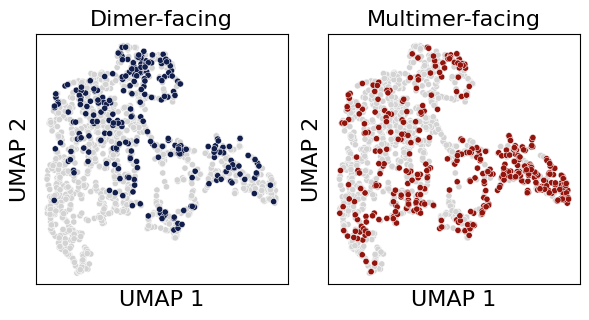

In [57]:
# Tetramer and dimer interacting positions
palette_interacting = \
    {
        'Syn':'darkgreen',
        'Dimer-facing':'#111D4A',
        'Multimer-facing':'#92140C',
        'Both':'#52192B',
        'Neither':'lightgrey'
    }

variants_assayed_umap_toplot = \
    df_profiles_merged[df_profiles_merged['Variant_Class'].isin(['Single Missense','Synonymous'])]
variants_assayed_umap_toplot['Label'] = variants_assayed_umap_toplot\
    .apply(lambda row: 'Syn' if row['Variant_Class']=='Synonymous' \
                           else 'Both' if int(row['Variant'][1:-1]) in (set(coil1b_tetramer_pos).intersection(set(coil1b_dimer_pos))) \
                           else 'Multimer-facing' if int(row['Variant'][1:-1]) in (coil1b_tetramer_pos+coil2a_tetramer_pos) \
                           else 'Dimer-facing' if int(row['Variant'][1:-1]) in coil1b_dimer_pos \
                           else 'Neither', axis=1)
variants_assayed_umap_toplot['zorder'] = \
    variants_assayed_umap_toplot['Label'].map(lambda x: 0 if x=='Neither' else\
                                                  1 if x=='Syn' else 2)
variants_assayed_umap_toplot.sort_values('zorder',inplace=True)

# Look at subplots - faceted
fig,axs=plt.subplots(figsize=(6,3.3), ncols=2, nrows=1, sharex=False, sharey=False)
umap_pos_toplot = \
    variants_assayed_umap_toplot.copy()
pos_to_show = ['Dimer-facing']
palette_interacting_toshow = \
    {k: (palette_interacting[k] if k in pos_to_show else 'lightgrey') for k in palette_interacting.keys()}
umap_pos_toplot['pos'] = umap_pos_toplot['Label'].map(lambda x: 1 if x in pos_to_show else 0)
sns.scatterplot(data=umap_pos_toplot.sort_values('pos'), 
                x='UMAP1', 
                y='UMAP2', 
                hue='Label', 
                palette=palette_interacting_toshow,
                s=20,
                legend=False,
                ax=axs[0]
               )
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel("UMAP 1", fontsize=16)
axs[0].set_ylabel("UMAP 2", fontsize=16)
axs[0].set_title('Dimer-facing', fontsize=16)

umap_pos_toplot = \
    variants_assayed_umap_toplot.copy()
pos_to_show = ['Multimer-facing']
palette_interacting_toshow = \
    {k: (palette_interacting[k] if k in pos_to_show else 'lightgrey') for k in palette_interacting.keys()}
umap_pos_toplot['pos'] = umap_pos_toplot['Label'].map(lambda x: 1 if x in pos_to_show else 0)
sns.scatterplot(data=umap_pos_toplot.sort_values('pos'), 
                x='UMAP1', 
                y='UMAP2', 
                hue='Label', 
                palette=palette_interacting_toshow,
                s=20,
                legend=False,
                ax=axs[1]
               )
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel("UMAP 1", fontsize=16)
axs[1].set_ylabel("UMAP 2", fontsize=16)
axs[1].set_title('Multimer-facing', fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/UMAP.bycoilinteraction.022525.pdf', dpi=600)


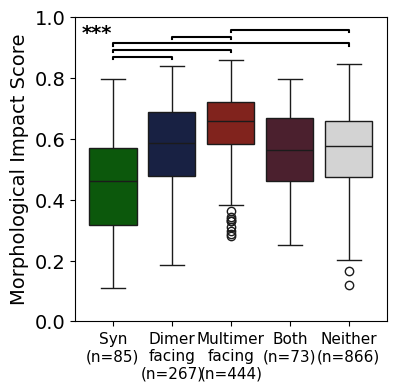

In [82]:
# Look at variants based on where they are in structure
fig,ax=plt.subplots(figsize=(4,4))
boxplot_with_significance(
    df=variants_assayed_umap_toplot,
    x_col='Label',
    y_col='Morphological Impact Score',
    hue_col='Label',
    palette=palette_interacting,
    order=['Syn','Dimer-facing','Multimer-facing','Both','Neither'],
    alpha=0.001,    # Show significance if p < 0.01
    pairs=[("Syn",s) for s in ['Dimer-facing','Multimer-facing','Neither']]+\
          [("Dimer-facing","Multimer-facing"),("Multimer-facing","Neither")],
    shared_label='***',
    offset=0.03,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel('Morphological Impact Score', fontsize=14)
ax.tick_params(labelsize=11)
#ax.set_xticklabels(["Syn","Dimer\nfacing","Multimer\nfacing","Both","Neither"])
ax.set_xticklabels([s.get_text().replace('-','\n') for s in ax.get_xticklabels()])
plt.ylim(0,1.0)
plt.tight_layout()
plt.yticks(fontsize=14)
plt.show()
fig.savefig('./consensus_plots/morphologicalimpact.byinteraction.022525.pdf', dpi=600)


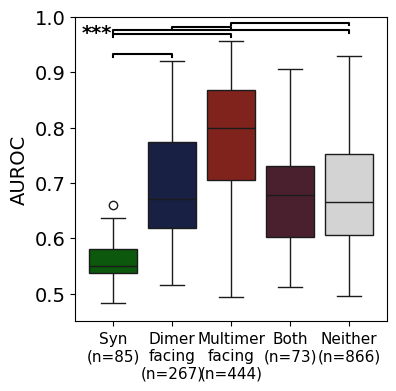

In [83]:
# Look at variants based on where they are in structure
fig,ax=plt.subplots(figsize=(4,4))
boxplot_with_significance(
    df=variants_assayed_umap_toplot.merge(roc_auc_lmna, on='Variant', how='inner'),
    x_col='Label',
    y_col='AUC ROC',
    hue_col='Label',
    palette=palette_interacting,
    order=['Syn','Dimer-facing','Multimer-facing','Both','Neither'],
    alpha=0.001,    # Show significance if p < 0.01
    pairs=[("Syn",s) for s in ['Dimer-facing','Multimer-facing','Neither']]+\
          [("Dimer-facing","Multimer-facing"),("Multimer-facing","Neither")],
    shared_label='***',
    offset=0.015,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel('AUROC', fontsize=14)
ax.tick_params(labelsize=11)
#ax.set_xticklabels(["Syn","Dimer\nfacing","Multimer\nfacing","Both","Neither"])
ax.set_xticklabels([s.get_text().replace('-','\n') for s in ax.get_xticklabels()])
plt.ylim(0.45,1.0)
plt.tight_layout()
plt.yticks(fontsize=14)
plt.show()
fig.savefig('./consensus_plots/auc_roc.byinteraction.052725.pdf', dpi=600)


In [27]:
# Add interacting annotations
colorpalette_interacting = \
    {
        'Dimer-facing':'#111D4A',
        'Multimer-facing':'#92140C',
        'Both':'#52192B'
    }

# Combine positions from the three lists.
# Assume coil1b_dimer_pos, coil1b_tetramer_pos, and coil2a_tetramer_pos
# are lists of positions (integers).
all_interacting = set(coil1b_dimer_pos) | set(coil1b_tetramer_pos) | set(coil2a_tetramer_pos)

# Create the annotation dictionary.
# For each interacting position, label it 'D' if only in the dimer list,
# 'T' if only in one of the tetramer lists, and 'D+T' if in both.
interacting_annotation_dict = {}
for pos in all_interacting:
    in_dimer = pos in coil1b_dimer_pos
    in_tetramer = (pos in coil1b_tetramer_pos) or (pos in coil2a_tetramer_pos)
    if in_dimer and in_tetramer:
        interacting_annotation_dict[pos] = 'Both'
    elif in_dimer:
        interacting_annotation_dict[pos] = 'Dimer-facing'
    elif in_tetramer:
        interacting_annotation_dict[pos] = 'Multimer-facing'

# Now, for positions within the specified range that are not interacting,
# assign the label 'Other'.
for i in range(start_pos, end_pos + 1):
    if i not in interacting_annotation_dict:
        interacting_annotation_dict[i] = 'Neither'


In [93]:
# Correlation between proline profiles only
df_variant_medianplusEMD_features_pca = \
    pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_PCA_021325.csv')
df_variant_medianplusEMD_features_pca.drop(columns='Unnamed: 0',inplace=True)
proline_PCA_embeddings = \
    df_variant_medianplusEMD_features_pca\
        .query('Variant_Class == "Single Missense"')
proline_PCA_embeddings['position'] = \
    proline_PCA_embeddings['Variant'].map(lambda s: int(s[1:-1]))
proline_PCA_embeddings['aaTo'] = \
    proline_PCA_embeddings['Variant'].map(lambda s: s[-1])
proline_PCA_embeddings = \
    proline_PCA_embeddings\
        .query('aaTo == "P"')\
        .drop(columns=['aaTo','Variant_Class','Variant'])

# Annotate with domain information
proline_PCA_embeddings['Domain'] = \
    proline_PCA_embeddings['position']\
        .map(lambda x: 'Syn' if x == 'Synonymous'\
                            else LMNA_domain_map[x])

# Proline palette
colorpalette_prolinecluster = ["#08605F","#A2AD59","#8E6E53"]

# Annotate with Tetramer vs Dimer information
proline_PCA_embeddings['Interaction'] = \
    proline_PCA_embeddings['position']\
        .map(lambda x: 'Syn' if x == 'Syn'\
                            else interacting_annotation_dict[int(x)],
            )
colorpalette_interacting['Syn']='darkgreen'
colorpalette_interacting['Neither']='white'

# Make similarity heatmap
proline_PCA_embeddings, similarity_df, linkage = \
    plot_correlation_positions(
        proline_PCA_embeddings,
        metric='correlation',
        annotation_cols=['Domain','Interaction'],
        annotation_palettes=[LMNA_domain_colors,colorpalette_interacting],
        cluster_palette=colorpalette_prolinecluster,
        perform_knn_imputation=True,
        annotate_clusters=True,
        n_clust_pos=3,
        y_pos_fontsize=6.5,
        cbar_pos=(0.12, 0.5, 0.015, 0.3),
        plot_filename = "./consensus_plots/LMNAT3.PCAcorrelation.prolinesonly.aapos.V2.pdf",
        figsize=(10,10),
        cluster_spacing=0.03,
        cluster_names={0:"\u03B1-helical",1:'Linker',2:'Linker-prox'},
        cluster_text_color={0:'white',1:'white',2:'white'},
        cluster_text_fontsize=14
    )


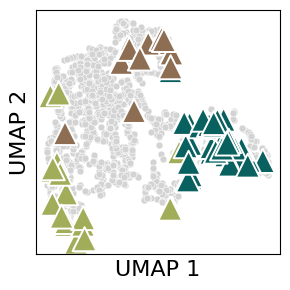

In [94]:
# Plot prolines on UMAP
variants_assayed_umap_toplot = \
    df_profiles_merged\
        .query('Variant_Class == "Single Missense"')

# Annotate with proline cluster
variants_assayed_umap_toplot['position'] = \
    variants_assayed_umap_toplot['Variant'].map(lambda x: int(x[1:-1]))
variants_assayed_umap_toplot['aato'] = \
    variants_assayed_umap_toplot['Variant'].map(lambda x: x[-1])
variants_assayed_umap_toplot_proline = \
    variants_assayed_umap_toplot\
        .query('aato == "P"')
variants_assayed_umap_toplot_proline = \
    variants_assayed_umap_toplot_proline\
        .merge(proline_PCA_embeddings.rename(columns={'Cluster':'Proline Cluster'}), on='position')

# UMAP
fig,ax=plt.subplots(figsize=(3,3))
sns.scatterplot(data=df_profiles_merged, 
                x='UMAP1', y='UMAP2', 
                c='lightgrey',
                s=25,
                ax=ax,
                legend=False
               )

sns.scatterplot(data=variants_assayed_umap_toplot_proline, 
                x='UMAP1', y='UMAP2', 
                hue='Proline Cluster', 
                palette={k:colorpalette_prolinecluster[k] \
                             for k in range(len(colorpalette_prolinecluster))},
                s=300,
                marker='^',
                ax=ax,
                legend=False
               )

# Remove x-axis tick labels and ticks
plt.xticks([])
plt.xlabel('UMAP 1', fontsize=16)

# Remove y-axis tick labels and ticks
plt.yticks([])
plt.ylabel('UMAP 2', fontsize=16)

# Add title
#plt.title('Proline Substitutions\nby Domain on UMAP', fontsize=16)

plt.tight_layout()

plt.show()
fig.savefig('./consensus_plots/LMNAT3.UMAP.prolinecluster.022025.pdf',dpi=600)


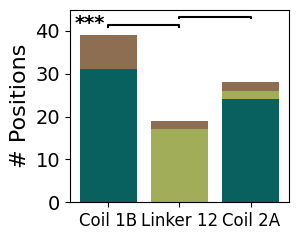

In [95]:
# Plot domain stacked bar chart of clusters
# Create stacked bar plot
# Step 1: Get the counts per Domain per Cluster
pos_average_tocount = \
    proline_PCA_embeddings[['Domain','Cluster']]\
        .query('Domain != "Syn"')
pos_average_tocount['Domain'] = \
    pd.Categorical(pos_average_tocount['Domain'],categories=['Coil 1B','Linker 12','Coil 2A'],ordered=True)
counts = pos_average_tocount\
            .groupby(['Domain', 'Cluster'])\
            .size()\
            .unstack(fill_value=0)

# Step 2: Define your color palette for clusters
colorpalette_positioncluster = {
    0: "#08605F",
    1: "#A2AD59",
    2: "#8E6E53"
}

# Step 3: Plot with significance
pairs = [('Coil 1B','Linker 12'), ('Linker 12','Coil 2A')]
fig,ax=plt.subplots(figsize=(3,2.5))
ax = stacked_bar_with_proportion_significance(
    counts, 
    pairs, 
    alpha=0.001,
    shared_label="***",
    title='',
    ylabel='# Positions',
    xlabel='',
    ax=ax,
    offset=0.05,
    colorpalette=colorpalette_positioncluster
)
plt.tight_layout()
plt.ylabel(ylabel='# Positions',fontsize=16)
plt.yticks(fontsize=14)
fig.savefig('./consensus_plots/LMNAT3.prolinepositions.clustersbydomain.022825.pdf', dpi=600)
plt.show()


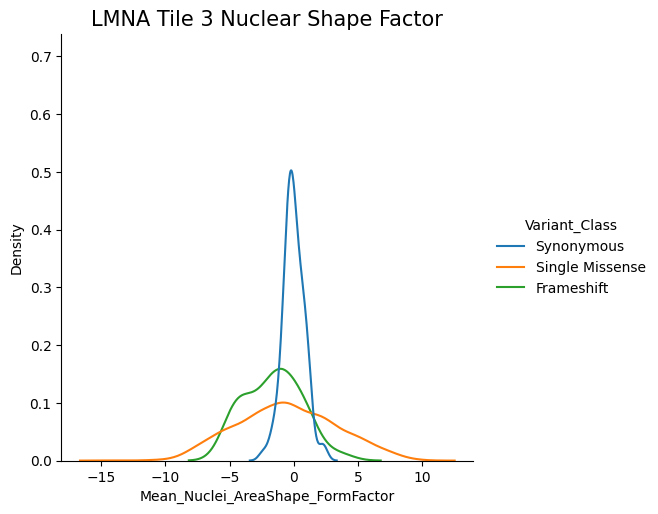

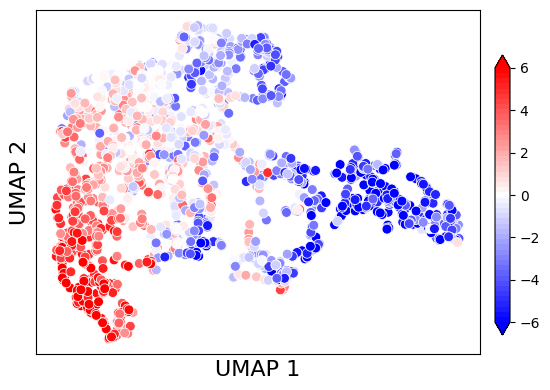

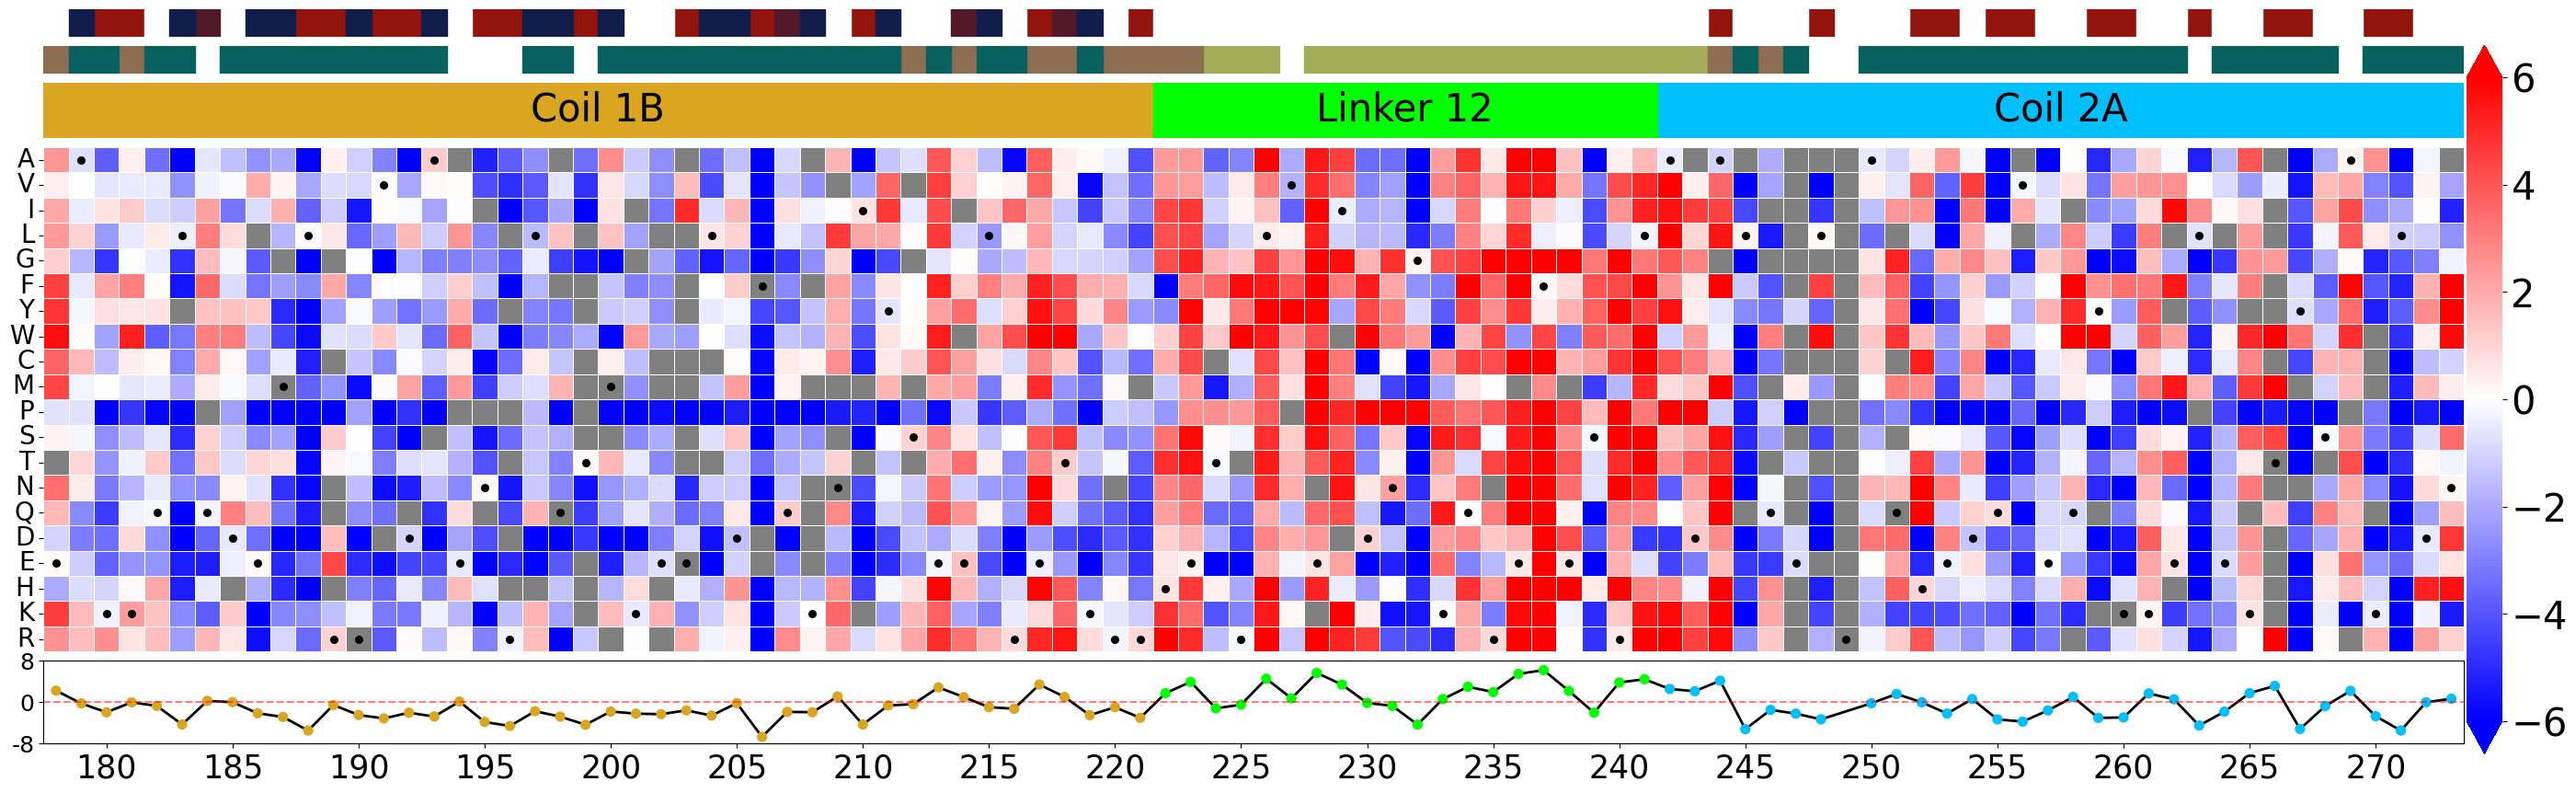

In [64]:
# Replot nuclear shape factor heatmap with position annotations
# Add proline annotation
proline_annotation_dict = \
    pd.Series(proline_PCA_embeddings['Cluster'].values,
              index=proline_PCA_embeddings['position'].values)\
        .to_dict()
for i in range(start_pos,end_pos+1):
    if i not in proline_annotation_dict.keys():
        proline_annotation_dict[i]=-1
colorpalette_positioncluster[-1]='white'

# Make heatmaps and other plots
feature_to_heatmap = 'Mean_Nuclei_AreaShape_FormFactor'
feature_scores, pymol_command = \
    plot_feature(variant_medians_merged,
                 umap_coords,
                 feature_to_heatmap,
                 "LMNA Tile 3 Nuclear Shape Factor",
                 "LMNA.T3.NucleiShapeFactor",
                  dist_plot=True,
                  umap_plot=True,
                  heatmap_plot=True,
                  pdb_plot=True,      
                  highlight_variants=False,
                  save_plots=True,
                  stops=False,
                  threentdels=False,
                  syn_zscore=False,
                  domain_map=LMNA_domain_map,
                  domain_colors=LMNA_domain_colors,
                  other_anno_map=[proline_annotation_dict,interacting_annotation_dict],
                  other_anno_colors=[colorpalette_positioncluster,colorpalette_interacting],
                  start_pos=start_pos,
                  end_pos=end_pos,
                  wt_nuc_seq=LMNA_WT_nuc_seq,
                  wt_aa_seq=LMNA_WT_aa_seq,
                  remove_nonclassified_variants=False,
                  input_pdb='./6jlb.pdb',
                  pymol_view=lmna_pymol_view,
                  image_size=(5000,2500),
                  dpi=1000,
                  pymol_exec="$HOME/pymol/pymol -c",
                  extra_pymol="show sticks\n",
                  dis_path='./consensus_plots/distribution/',
                  heatmap_path='./consensus_plots/heatmap/',
                  umap_path='./consensus_plots/umap/',
                  pdb_path='./consensus_plots/pdb/',
                  heatmap_figure_size=(40,20),
                  vmin=-6,
                  vmax=6
                )


In [65]:
# Now, cluster only those positions in the coil cluster by average profiles
coilpos_tocluster_byprolinePCA = \
    proline_PCA_embeddings.query('Cluster == 0')['position'].values

# Plot cluster plot over positions, averaged variants - PCA space and correlation distance
# Subset Single Missense
colorpalette_positioncluster = \
    [
        "#6B62CB",
        "#E91CB2",
        "#91BAD6"
    ]
df_variant_medianplusEMD_features_pca = \
    pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_PCA_021325.csv')
df_variant_medianplusEMD_features_pca.drop(columns='Unnamed: 0', inplace=True)
n_comp_pca=12
n_variants_perpos_filter=15

variants_assayed_umap_toplot_missenseonly = \
    df_variant_medianplusEMD_features_pca\
        .query("Variant_Class == 'Single Missense'")
variants_assayed_umap_toplot_missenseonly['position'] = \
    variants_assayed_umap_toplot_missenseonly['Variant'].map(lambda s: int(s[1:-1]))
aapos_represented = \
    (variants_assayed_umap_toplot_missenseonly['position'].value_counts() >= n_variants_perpos_filter)
aapos_represented = aapos_represented[aapos_represented].index
aapos_represented = sorted(aapos_represented)
variants_assayed_umap_toplot_missenseonly = \
    variants_assayed_umap_toplot_missenseonly\
        .query('position.isin(@aapos_represented)')\
        .query('position.isin(@coilpos_tocluster_byprolinePCA)')

# Perform profile averaging
pca_dim = ['PC'+str(i) for i in range(1,n_comp_pca+1)]
syn_profile = \
    df_variant_medianplusEMD_features_pca[pca_dim+['Variant_Class']]\
        .query('Variant_Class == "Synonymous"')\
        .drop(columns='Variant_Class')\
        .mean()
syn_profile['position']='Syn'
pos_averaged_profiles = \
    variants_assayed_umap_toplot_missenseonly[pca_dim+['position']]\
        .groupby('position')\
        .mean()\
        .reset_index()
pos_averaged_profiles['position'] = pos_averaged_profiles['position'].astype(str)
pos_averaged_profiles.loc[-1] = syn_profile.T

# Annotate with domain information
pos_averaged_profiles['Domain'] = \
    pos_averaged_profiles['position']\
        .map(lambda x: 'Syn' if x == 'Syn'\
                            else LMNA_domain_map[int(x)],
            )

# Annotate with Tetramer vs Dimer information
pos_averaged_profiles['Interaction'] = \
    pos_averaged_profiles['position']\
        .map(lambda x: 'Syn' if x == 'Syn'\
                            else interacting_annotation_dict[int(x)],
            )
colorpalette_interacting['Syn']='darkgreen'
domain_cp = {**LMNA_domain_colors, 'Syn': 'darkgreen'}

# Make correlation heatmap
nclust_coilpos=3
coilpos_averaged_profiles, similarity_df, linkage = \
    plot_correlation_positions(
        pos_averaged_profiles,
        metric='correlation',
        annotation_cols=['Domain','Interaction'],
        annotation_palettes=[domain_cp,colorpalette_interacting],
        cluster_palette=colorpalette_positioncluster,
        perform_knn_imputation=False,
        fillnaval=0,
        annotate_clusters=True,
        n_clust_pos=nclust_coilpos,
        y_pos_fontsize=8,
        cbar_pos=(0.12, 0.65, 0.015, 0.15),
        plot_filename = "./consensus_plots/LMNAT3.PCAcorrelation.coilpositionsonly.averagedprofiles.aapos.V2.032325.pdf",
        figsize=(8,8),
        cluster_spacing=0.04,
        cluster_names={0:'Low Impact',1:'Strongly Agg.',2:'Low Abund.'},
        cluster_text_color={0:'white',1:'white',2:'white'},
        cluster_text_fontsize=11
    )


In [66]:
# Plot clusters on structure - A11 and A22
input_to_paint = \
    pos_averaged_profiles\
        [['position','Cluster']]\
        .reset_index(drop=True)\
        .query('position != "Syn"')\
        .rename(columns={'Cluster':'score'})
input_to_paint['position'] = input_to_paint['position'].astype(int)
input_to_paint_toplot = input_to_paint.copy()
input_to_paint_toplot['score'] = input_to_paint_toplot['score'] + 1

# Paint all colors at once
lmna_pymol_view = \
    '''set_view (\
        -0.915147185,    0.403044611,   -0.007183676,\
        -0.175614133,   -0.414666086,   -0.892865419,\
        -0.362844229,   -0.815845907,    0.450264663,\
         0.000000000,    0.000000000, -382.015167236,\
      -190.245574951, -108.335136414,  109.851905823,\
       301.183654785,  462.846679688,  -20.000000000 )'''
start_pos=178
end_pos=273
n_clust_pos=3
pymol_command = \
    paint_structure(
        input_to_paint_toplot,
        output_suffix='LMNA_dimer_PCAaveragedclusters',
        output_dir="./consensus_plots/pdb/",
        input_pdb='./6jlb.pdb',
        pymol_view=lmna_pymol_view,
        start_pos=start_pos,
        end_pos=end_pos,
        pymol_exec="$HOME/pymol/pymol -c",
        image_size=(5000,2500),
        dpi=1000,
        vmin=0,
        vmax=3,
        extra_pymol="show spheres\n",
        discrete_coloring=True,
        discrete_colors=["#2F2F2F"]+colorpalette_positioncluster
        )
!{pymol_command}

# Paint all colors at once
lmna_pymol_view2 = \
    '''set_view (\
         0.128099561,   -0.553015828,    0.823264420,\
         0.121202230,    0.832608640,    0.540436924,\
        -0.984324038,    0.030553162,    0.173684672,\
         0.000030637,   -0.000129715, -390.408966064,\
      -195.511444092,  -99.926048279, -157.834701538,\
        82.949302673,  697.868286133,  -20.000000000 )'''
start_pos=178
end_pos=273
n_clust_pos=3
pymol_command = \
    paint_structure(
        input_to_paint_toplot,
        output_suffix='LMNA_A22_PCAaveragedclusters',
        output_dir="./consensus_plots/pdb/",
        input_pdb='./molce-46-5-309-supple2.pdb',
        pymol_view=lmna_pymol_view2,
        start_pos=start_pos,
        end_pos=end_pos,
        pymol_exec="$HOME/pymol/pymol -c",
        image_size=(5000,2500),
        dpi=1000,
        extra_pymol="show sticks\n",
        vmin=0,
        vmax=n_clust_pos,
        discrete_coloring=True,
        discrete_colors=["#2F2F2F"]+colorpalette_positioncluster
)
!{pymol_command}


 PyMOL(TM) 3.1.6.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 56 CPU cores.  Enabled multithreaded rendering.
 CmdLoad: "" loaded as "6jlb_LMNA_dimer_PCAaveragedclusters".
PyMOL>set_view (        -0.915147185,    0.403044611,   -0.007183676,        -0.175614133,   -0.414666086,   -0.892865419,        -0.362844229,   -0.815845907,    0.450264663,         0.000000000,    0.000000000, -382.015167236,      -190.245574951, -108.335136414,  109.851905823,       301.183654785,  462.846679688,  -20.000000000 )
 Scene: view updated.
PyMOL>select resi 178-273
 Selector: selection "sele" defined with 2684 atoms.
PyMOL>remove solvent
PyMOL>color grey, not sele
 Executive: Colored 4477 atoms.
PyMOL>spectrum b, 0x2F2F2F 0x6B62CB 0xE91CB2 0x91BAD6, sele, minimum=0, maximum=3
 Spectrum: range (0.00000 to 3.00000)
PyMOL>show spheres
PyMOL>ray
 Ray: render time: 0.51 sec. = 7118.2 frames/hour (0.51 sec. accum.).
PyMOL>

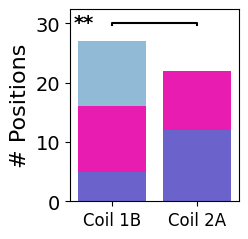

In [67]:
# Plot domain stacked bar chart of clusters
# Create stacked bar plot
# Step 1: Get the counts per Domain per Cluster
pos_average_tocount = \
    coilpos_averaged_profiles[['Domain','Cluster']]\
        .query('Domain != "Syn"')
pos_average_tocount['Domain'] = \
    pd.Categorical(pos_average_tocount['Domain'],categories=['Coil 1B','Coil 2A'],ordered=True)
counts = pos_average_tocount\
            .groupby(['Domain', 'Cluster'])\
            .size()\
            .unstack(fill_value=0)

# Step 3: Define your color palette for clusters
colorpalette_positioncluster = {
    0: "#6B62CB",
    1: "#E91CB2",
    2: "#91BAD6"
}
pairs = [('Coil 1B','Coil 2A')]
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax = stacked_bar_with_proportion_significance(
    counts, 
    pairs, 
    alpha=0.01,
    shared_label="**",
    title='',
    ylabel='# Positions',
    xlabel='',
    ax=ax,
    offset=0.1,
    colorpalette=colorpalette_positioncluster,
    pseudocount=1
)
plt.tight_layout()
plt.ylabel('# Positions',fontsize=16)
plt.yticks(fontsize=14)
fig.savefig('./consensus_plots/LMNAT3.deepcoilposition.clustersbydomain.022825.pdf', dpi=600)
plt.show()


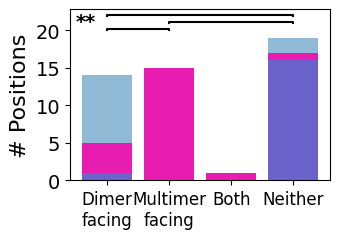

In [68]:
# Plot domain stacked bar chart of clusters
# Create stacked bar plot
# Step 1: Get the counts per Domain per Cluster
pos_average_tocount = \
    coilpos_averaged_profiles[['Interaction','Cluster']]\
        .query('Interaction != "Syn"')
pos_average_tocount['Interaction'] = \
    pd.Categorical(pos_average_tocount['Interaction'],categories=['Dimer-facing','Multimer-facing','Both','Neither'],ordered=True)
counts = pos_average_tocount\
            .groupby(['Interaction', 'Cluster'])\
            .size()\
            .unstack(fill_value=0)

# Step 2: Define your color palette for clusters
colorpalette_positioncluster = {
    0: "#6B62CB",
    1: "#E91CB2",
    2: "#91BAD6"
}

# Step 3: Create the stacked bar plot
fig, ax = plt.subplots(figsize=(3.5,2.5))
pairs = [('Multimer-facing','Dimer-facing'),('Multimer-facing','Neither'),('Dimer-facing','Neither')]
ax = stacked_bar_with_proportion_significance(
    counts, 
    pairs, 
    alpha=0.01,
    shared_label="**",
    title='',
    ylabel='# Positions',
    xlabel='',
    ax=ax,
    offset=0.05,
    colorpalette=colorpalette_positioncluster,
    pseudocount=1
)
ax.set_xticklabels(["Dimer\nfacing","Multimer\nfacing","Both","Neither"])
plt.ylabel('# Positions',fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.deepcoilposition.clustersbyinteraction.022825.pdf', dpi=600)
plt.show()


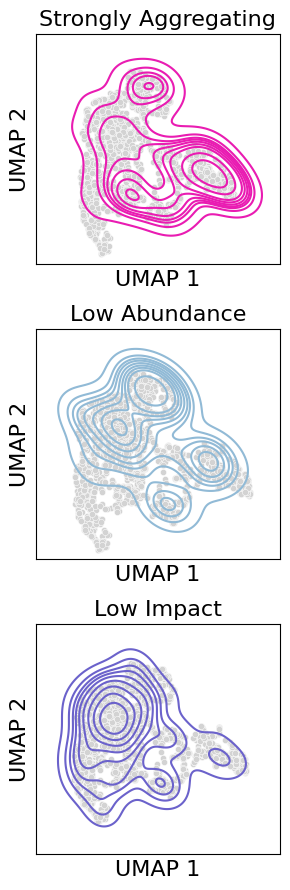

In [69]:
#### Plot clusters of coil positions on UMAP - density plot
variant_profiles_toplot = \
    df_profiles_merged.copy()
variant_profiles_singlemissense_toplot = \
    variant_profiles_toplot\
        .query('Variant_Class == "Single Missense"')
variant_profiles_singlemissense_toplot['position'] = \
    variant_profiles_singlemissense_toplot['Variant'].map(lambda x: (x[1:-1]))
cluster_labels = ['Low Impact','Strongly Aggregating','Low Abundance']
clusters_in_order = ['Strongly Aggregating','Low Abundance','Low Impact']
clusters_in_order_num = [1,2,0]

# Plot clusters on UMAP separately
fig,axs=plt.subplots(figsize=(3,9),nrows=3,sharex=False,sharey=False)
for k,c in enumerate(clusters_in_order_num):
    pos_in_cluster = \
        coilpos_averaged_profiles[['position','Cluster']]\
            .query('position != "Synonymous"')\
            .query('Cluster == @c')\
            ['position'].values
    ax=axs[k]
    sns.scatterplot(data=variant_profiles_toplot, 
                    x='UMAP1', 
                    y='UMAP2', 
                    c='lightgrey',
                    s=20,
                    ax=ax,
                    legend=False)
    sns.kdeplot(data=variant_profiles_singlemissense_toplot.query('position in @pos_in_cluster'), 
                x="UMAP1", 
                y="UMAP2", 
                color=colorpalette_positioncluster[c], 
                fill=False,
                ax=ax,
                legend=False
               )
    ax.set_ylabel('UMAP 2',fontsize=16)
    ax.set_xlabel('UMAP 1',fontsize=16)
    ax.set_title(clusters_in_order[k], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.UMAP.coilpositionclusters.density.022025.pdf', dpi=600)
plt.show()


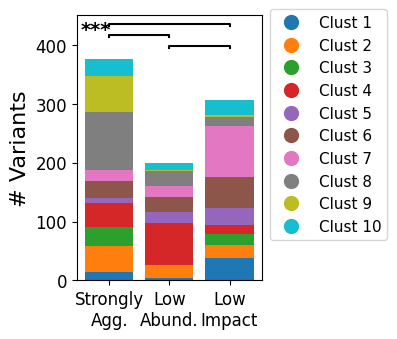

In [85]:
# Look at distribution of mutations at deep coil clusters on Louvain Clusters
n_louvain_clust=10
variant_profiles_toplot = \
    df_profiles_merged.copy()
variant_profiles_toplot = \
    variant_profiles_toplot\
        .query('Variant_Class == "Single Missense"')
variant_profiles_toplot['position'] = \
    variant_profiles_toplot['Variant'].map(lambda x: (x[1:-1]))
variant_profiles_toplot = \
    variant_profiles_toplot\
        .query('position in @coilpos_averaged_profiles["position"].values')\
        .merge(coilpos_averaged_profiles[['position','Cluster']]\
                   .rename(columns={'Cluster':'Position Cluster'}),
                   on='position')
cluster_labels = ['Low\nImpact','Strongly\nAgg.','Low\nAbund.']
variant_profiles_toplot['Position Cluster'] = \
    pd.Categorical(
        variant_profiles_toplot['Position Cluster'].map(lambda x: cluster_labels[x]),
        categories=['Strongly\nAgg.','Low\nAbund.','Low\nImpact'],
        ordered=True
    )
variant_profiles_toplot.sort_values(by='Position Cluster', inplace=True)
counts = variant_profiles_toplot\
            .groupby(['Position Cluster','Cluster'])\
            .size()\
            .unstack(fill_value=0)

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(4,3.5))
pairs = [('Low\nImpact','Low\nAbund.'),('Strongly\nAgg.','Low\nAbund.'),('Low\nImpact','Strongly\nAgg.')]
ax = stacked_bar_with_proportion_significance(
    counts, 
    pairs, 
    alpha=0.001,
    shared_label="***",
    title='',
    ylabel='# Variants',
    xlabel='',
    ax=ax,
    offset=0.05,
    colorpalette={(i+1):sns.color_palette()[i] for i in range(n_louvain_clust)},
    pseudocount=1
)
plt.legend(
    bbox_to_anchor=(1,1.05),
    handles=[Line2D([0], [0], 
                    marker='o', 
                    color='w',
                    markerfacecolor=sns.color_palette()[i],
                    label='Clust '+str(i+1), 
                    markersize=12) \
             for i in range(n_louvain_clust)],
    fontsize=11
          )
plt.tight_layout()
plt.ylabel('# Variants',fontsize=16)
plt.yticks(fontsize=12)
fig.savefig('./consensus_plots/LMNAT3.deepcoilposition.louvainclusters.022825.pdf', dpi=600)
plt.show()


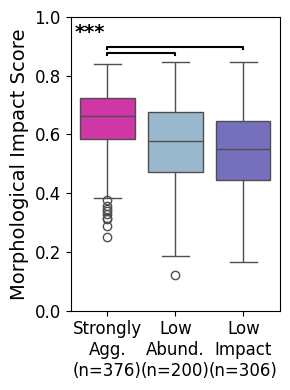

In [81]:
# Look at variants based on where they are in structure
fig,ax=plt.subplots(figsize=(3,4))
posclusters=['Strongly\nAgg.','Low\nAbund.','Low\nImpact']
boxplot_with_significance(
    df=variant_profiles_toplot,
    x_col='Position Cluster',
    y_col='Morphological Impact Score',
    hue_col='Position Cluster',
    palette={'Low\nImpact':colorpalette_positioncluster[0],
             'Strongly\nAgg.':colorpalette_positioncluster[1],
             'Low\nAbund.':colorpalette_positioncluster[2]},
    order=posclusters,
    alpha=0.001,    # Show significance if p < 0.001,
    pairs=list(itertools.combinations(posclusters, 2)),
    shared_label='***',
    offset=0.03,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel('Morphological Impact Score', fontsize=14)
ax.tick_params(labelsize=12)
#ax.set_title('Deep Coil Variant\n Impacts by Position', fontsize=14)
plt.ylim(0,1.0)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/morphologicalimpact.bydeepcoilpositioncluster.030425.pdf', dpi=600)


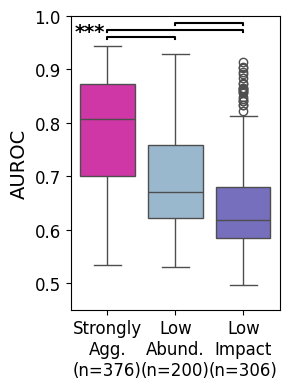

In [80]:
# Look at variants based on where they are in structure
fig,ax=plt.subplots(figsize=(3,4))
posclusters=['Strongly\nAgg.','Low\nAbund.','Low\nImpact']
boxplot_with_significance(
    df=variant_profiles_toplot.merge(roc_auc_lmna, on='Variant', how='inner'),
    x_col='Position Cluster',
    y_col='AUC ROC',
    hue_col='Position Cluster',
    palette={'Low\nImpact':colorpalette_positioncluster[0],
             'Strongly\nAgg.':colorpalette_positioncluster[1],
             'Low\nAbund.':colorpalette_positioncluster[2]},
    order=posclusters,
    alpha=0.001,    # Show significance if p < 0.001,
    pairs=list(itertools.combinations(posclusters, 2)),
    shared_label='***',
    offset=0.03,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel('AUROC', fontsize=14)
ax.tick_params(labelsize=12)
#ax.set_title('Deep Coil Variant\n Impacts by Position', fontsize=14)
plt.ylim(0.45,1)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/auc_roc.bydeepcoilpositioncluster.052725.pdf', dpi=600)


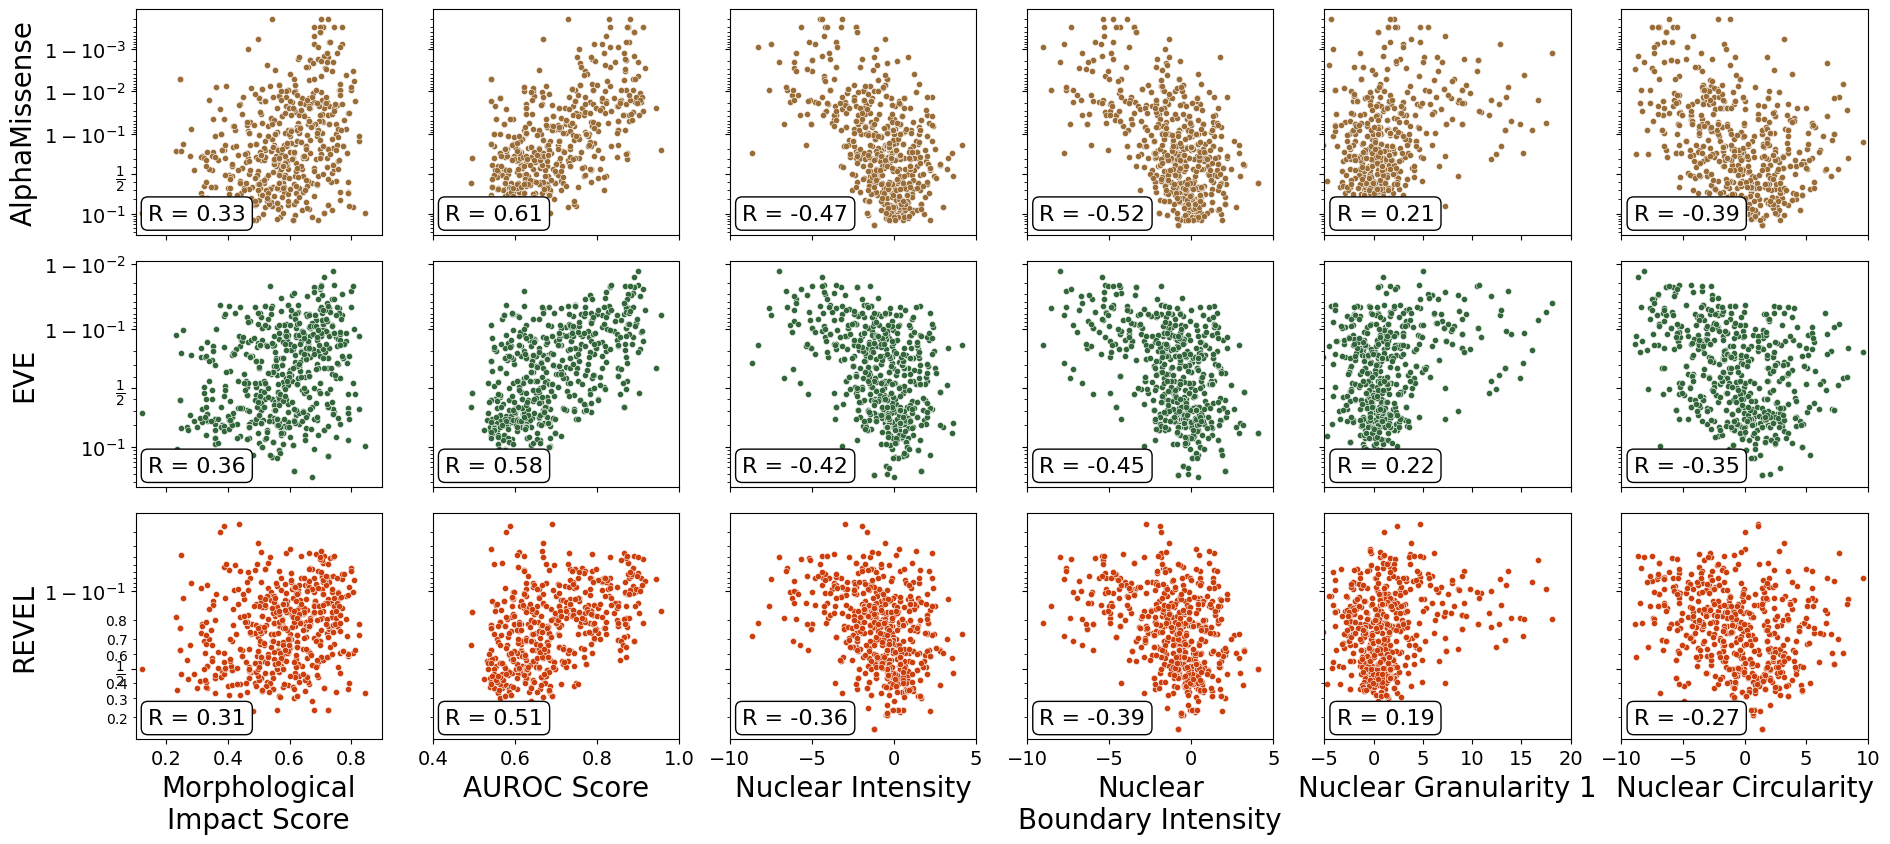

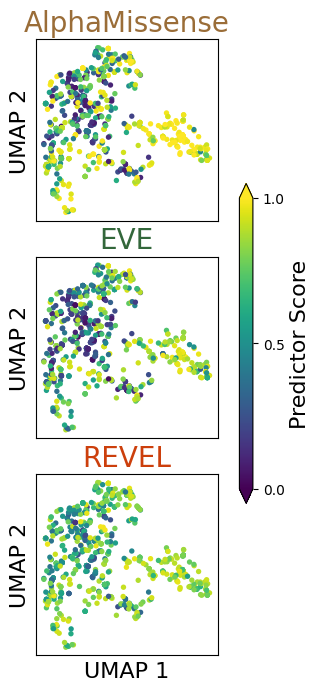

In [75]:
# Get merged VEP scores
lmna_VEP_merged = \
    pd.merge(
        pd.merge(
            lmna_variants_spliceAIfiltered.rename(columns={'protein_variant':'Variant',
                                                           'am_pathogenicity':'AlphaMissense'}),
            lmna_variants_EVE.rename(columns={'EVE_scores_ASM':'EVE'}),
            on='Variant',
            how='inner'
        ),
        lmna_variants_REVEL,
        on='Variant',
        how='inner'
    )

# Plot VEP scores against MIS, landmark features
landmark_features = \
    [
        'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
        'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
        'Mean_NucleiExpanded_Granularity_1_CH1',
        'Mean_Nuclei_AreaShape_FormFactor',
    ]
features = ['Morphological Impact Score','AUC ROC'] + landmark_features
df_toplot = \
    df_profiles_merged\
        .merge(lmna_VEP_merged,on='Variant',how='inner')\
        [['Variant','EVE','REVEL','AlphaMissense','UMAP1','UMAP2','Morphological Impact Score']]\
        .merge(variant_medians_merged,on='Variant',how='inner')\
        .merge(roc_auc_lmna, on='Variant', how='left')
lim_features = {
    'Morphological Impact Score':[0.1,0.9],
    'AUC ROC':[0.4,1],
    'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1':[-10,5],
    'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1':[-10,5],
    'Mean_NucleiExpanded_Granularity_1_CH1':[-5,20],
    'Mean_Nuclei_AreaShape_FormFactor':[-10,10]
}
name_features = {
    'Morphological Impact Score':'Morphological\nImpact Score',
    'AUC ROC':'AUROC Score',
    'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1':'Nuclear Intensity',
    'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1':'Nuclear\nBoundary Intensity',
    'Mean_NucleiExpanded_Granularity_1_CH1':'Nuclear Granularity 1',
    'Mean_Nuclei_AreaShape_FormFactor':'Nuclear Circularity'
}
predictors = ['AlphaMissense', 'EVE', 'REVEL']
colors = {
    'AlphaMissense': '#9A6D38',
    'EVE':           '#33673B',
    'REVEL':         '#CC3F0C'
}

# 3) make a grid of subplots
fig, axs = plt.subplots(
    nrows=len(predictors),
    ncols=len(features),
    figsize=(3*len(features)+1, 3*len(predictors)),
    sharex='col',
    sharey='row'
)

# 4) fill in each cell
for i, pred in enumerate(predictors):
    for j, feat in enumerate(features):
        ax = axs[i, j]
        sns.scatterplot(
            data=df_toplot,
            x=feat, y=pred,
            ax=ax,
            color=colors[pred],
            s=20,
            legend=False
        )
        # compute & annotate Pearson r
        sub = df_toplot[[feat, pred]].dropna()
        r, _ = ss.pearsonr(sub[feat], logit(sub[pred]))
        ax.text(
            0.05, 0.05,
            f"R = {r:.2f}",
            transform=ax.transAxes,
            fontsize=16,
            va='bottom',
            bbox=dict(
                boxstyle="round,pad=0.3",  # rounded box with a little padding
                facecolor="white",         # fill color
                edgecolor="black",         # box edge color
                linewidth=1                # edge line width
            )
        )
        ax.set_xlim(lim_features[feat])
        # logistic scale for the VEP scores
        ax.set_yscale("logit")
        # only bottom row gets x-labels
        if i == len(predictors) - 1:
            ax.set_xlabel(name_features[feat], fontsize=20)
            ax.tick_params(labelsize=14)
        else:
            ax.set_xlabel("")  # hide intermediate x-labels
        # only first column gets y-labels
        if j == 0:
            ax.set_ylabel(pred, fontsize=20)
            ax.tick_params(labelsize=14)
        else:
            ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
fig.savefig("./consensus_plots/LMNAT3.VEPbylandmarkfeatures.052025.pdf", dpi=300)

#Plot VEP scores on UMAP
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=1, clip=True)

# set up 3-panel UMAP
fig, axs = plt.subplots(figsize=(2.7, 8), nrows=3, sharex=True, sharey=False)

for ax, pred in zip(axs, ['AlphaMissense','EVE','REVEL']):
    sc = ax.scatter(
        df_toplot['UMAP1'],
        df_toplot['UMAP2'],
        c = df_toplot[pred],
        cmap = cmap,
        norm = norm,
        s = 15,
        edgecolors='none'
    )
    ax.set_title(pred, fontsize=20, color=colors[pred])
    ax.set_ylabel('UMAP 2', fontsize=16)
    ax.set_xticks([]); ax.set_yticks([])

# make room on the right for the colorbar
axs[-1].set_xlabel('UMAP 1', fontsize=16)
fig.subplots_adjust(right=0.8)

# add a single colorbar outside the 3 plots
cbar_ax = fig.add_axes([0.88, 0.3, 0.05, 0.4])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.set_label('Predictor Score', fontsize=16)
cbar.set_ticks([0, 0.5, 1])
plt.show()
fig.savefig("./consensus_plots/LMNAT3.VEPonUMAP.052025.pdf", dpi=300, bbox_inches='tight')
